In [349]:
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [350]:
#Load dataset from CSV file
dataset = pd.read_csv('data/dataset.csv')

In [351]:
#Add all sales to get Total Net Sale
df = dataset.groupby('date', as_index = False).sum().round(2)

In [352]:
df

date       order_id  quantity  unit_price  unit_cogs  brand_id  \
0    2019-06-01   247010138661       157     3458.94    1943.87      8542   
1    2019-06-02    17100732010         7       85.17      46.27       331   
2    2019-06-03    95004080862        37     1351.81     818.72      3089   
3    2019-06-04  4913608532244      2583    70452.71   42176.95    146898   
4    2019-06-05  5088416821504      2586    65441.95   20088.45    143445   
..          ...            ...       ...         ...        ...       ...   
953  2022-01-10  8113663535614      3938   107042.19   67683.67    226352   
954  2022-01-11  7847468373138      3773   110367.10   71173.65    222232   
955  2022-01-12  7543872212697      3721    99703.79   64159.69    213979   
956  2022-01-13  7403076990931      3782    94480.41   60457.82    203970   
957  2022-01-14  1524616614764       751    18190.65   11689.01     41000   

     net_sales  gross_profit  
0      4121.07       1879.38  
1        78.76         32.49  
2      1354.00        491.23  
3     70505.74      28270.82  
4     66236.44      45663.40  
..         ...           ...  
953  109472.94      40239.47  
954  112798.63      40030.77  
955  102618.52      36740.92  
956   99848.20      36292.39  
957   18895.40       6775.38  

[958 rows x 8 columns]

In [7]:
#Dataset date range
print( 'Dataset date range starts on', df['date'].min(), 'and ends on', df['date'].max())

Dataset date range starts on 2019-06-01 and ends on 2022-01-14


#### 1. Building a Prophet model to forecast Sales 

##### 1.1. Total Sales 

##### 1.1.1. Forecast

In [179]:
#Build the df model 
df_model = df[['date','net_sales']].rename(columns={'date': 'ds','net_sales':'y' })
df_model.tail()

ds          y
953  2022-01-10  109472.94
954  2022-01-11  112798.63
955  2022-01-12  102618.52
956  2022-01-13   99848.20
957  2022-01-14   18895.40

In [180]:
N_all = df_model.shape[0]
N_train_all = N_all - 60

df_model_train = df_model.iloc[:N_train_all,:]
df_model_test = df_model.iloc[N_train_all:,:]

In [181]:
#Creat instance and fit the model
m = Prophet()
m.fit(df_model_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [182]:
#Configure the length of the prediction
future = m.make_future_dataframe(periods=60)
future.tail()

ds
953 2022-01-10
954 2022-01-11
955 2022-01-12
956 2022-01-13
957 2022-01-14

In [183]:
#Forecast the future values
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat    yhat_lower     yhat_upper
953 2022-01-10  115748.333035  99144.167747  132835.776443
954 2022-01-11  112414.504234  95703.292871  129558.183702
955 2022-01-12  110367.012377  92326.045887  126479.024316
956 2022-01-13  108050.658300  90055.817911  124859.229995
957 2022-01-14  105722.469936  87646.665057  122206.554456

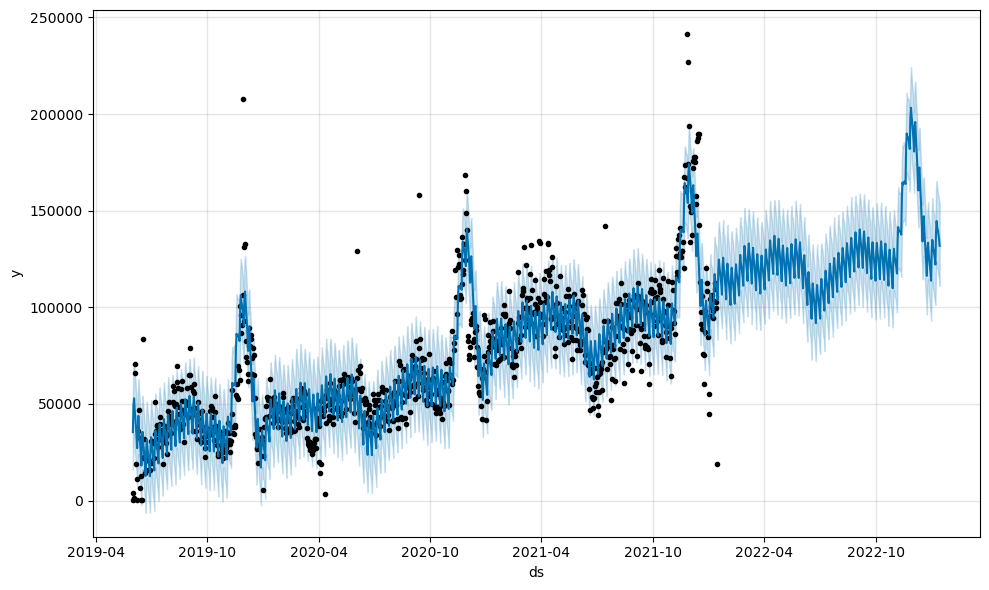

In [12]:
#Graph of historical and forecasted net sales values
fig1 = m.plot(forecast)

##### *Metrics Calculation*

In [187]:
r2_score = metrics.r2_score(list(df_model_test['y']), list(forecast.loc[N_train_all:,'yhat']))    
print (r2_score)
print ('The r2 is equals to', r2_score)

mae = metrics.mean_absolute_error(list(df_model_test['y']), list(forecast.loc[N_train_all:,'yhat']))    
print ('The MAE is equals to', mae)

0.4646126410973975
The r2 is equals to 0.4646126410973975
The MAE is equals to 22058.565678923416


##### *Plot predicted Vs true values*

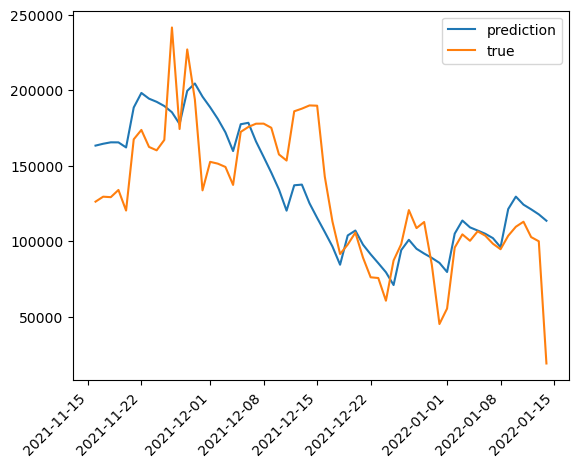

In [193]:
plt.plot(forecast.loc[N_train_all:,'ds'],forecast.loc[N_train_all:,'yhat'], label = 'prediction')
plt.plot( pd.to_datetime(df_model_test['ds']),df_model_test['y'], label = 'true')
plt.xticks(rotation=45, ha='right')
plt.legend()

##### *Grid Search*

In [189]:
# Create the grid
changepoint_prior_scale = [0.01, 0.03, 0.05, 0.07] # default 0.05
seasonality_prior_scale = [1, 5, 10, 15] # default 10
seasonality_mode = ['additive', 'multiplicative']
changepoint_range = [0.6, 0.7, 0.8, 0.9] # default 0.8

# Compute the total number of iterations
total_iter = len(changepoint_prior_scale)*len(seasonality_prior_scale)*len(seasonality_mode)*len(changepoint_range)
print(f'Number of iterations : {total_iter}')

# Loop over the parameters, build and assess the models
grid_search_results = []
iteration = 1
for cps in changepoint_prior_scale:
    for sps in seasonality_prior_scale:
        for sm in seasonality_mode:
            for cr in changepoint_range:
                m = Prophet(changepoint_prior_scale = cps, 
                                seasonality_prior_scale = sps, 
                                seasonality_mode = sm, 
                                changepoint_range = cr)
                model = m.fit(df_model_train)
                future = model.make_future_dataframe(periods=60, freq='D')
                forecast = model.predict(future) 

                r2_score = metrics.r2_score(list(df_model_test['y']), list(forecast.loc[N_train_all:,'yhat']))   
                mae = metrics.mean_absolute_error(list(df_model_test['y']), list(forecast.loc[N_train_all:,'yhat']))
                mse = metrics.mean_squared_error(list(df_model_test['y']), list(forecast.loc[N_train_all:,'yhat']))
                
                print(f'iteration : {iteration} / {total_iter} ')
                print(f'r2_score : {r2_score}')
                print(f'mae : {mae}')
                print(f'mse : {mse}')
                
                grid_search_results.append([iteration, cps, sps, sm, cr, r2_score, mae, mse])
                iteration += 1

# Store the results in a dataframe
grid_search_df_all = pd.DataFrame(grid_search_results, columns = ['iteration', 'cps', 'sps', 'sm', 'cr', 'r2_score', 'mae', 'mse'])


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Number of iterations : 128


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 1 / 128 
r2_score : 0.5054513329905039
mae : 22079.63768586521
mse : 969008139.9377683


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 2 / 128 
r2_score : 0.5055321498479559
mae : 22076.451306497278
mse : 968849789.1061126


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 3 / 128 
r2_score : 0.5060774076974749
mae : 22065.10097495955
mse : 967781422.472463


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 4 / 128 
r2_score : 0.5049944954718513
mae : 22048.638304866163
mse : 969903257.6556671


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 5 / 128 
r2_score : 0.5130098496770004
mae : 24514.4809596412
mse : 954198143.0989136


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 6 / 128 
r2_score : 0.5106336158538781
mae : 24617.511709331815
mse : 958854085.1135275


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 7 / 128 
r2_score : 0.5139693443909537
mae : 24441.187093348744
mse : 952318129.5631979


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 8 / 128 
r2_score : 0.5005351015352101
mae : 25093.91516119331
mse : 978640899.2914729


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 9 / 128 
r2_score : 0.5061483127088564
mae : 22088.839199795646
mse : 967642492.7011896


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 10 / 128 
r2_score : 0.5060913194046908
mae : 22092.446497440764
mse : 967754164.1692222


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 11 / 128 
r2_score : 0.504097864814192
mae : 22021.6739187728
mse : 971660096.6964905


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 12 / 128 
r2_score : 0.5064560339847413
mae : 22090.771758103536
mse : 967039550.1779239


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 13 / 128 
r2_score : 0.5063893273743104
mae : 24792.88068847585
mse : 967170253.6916672


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 14 / 128 
r2_score : 0.5115298980954424
mae : 24595.21808133914
mse : 957097928.7517903


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 15 / 128 
r2_score : 0.5113073770871412
mae : 24580.55190656551
mse : 957533931.6828159


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 16 / 128 
r2_score : 0.5093960118397245
mae : 24700.764771190585
mse : 961279020.0971487


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 17 / 128 
r2_score : 0.5064907764813571
mae : 22099.05830016979
mse : 966971476.468968


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 18 / 128 
r2_score : 0.5063405075077486
mae : 22096.41668707697
mse : 967265910.2998937


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 19 / 128 
r2_score : 0.5047482378643775
mae : 22044.86870253621
mse : 970385769.5742748


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 20 / 128 
r2_score : 0.5043473705353834
mae : 22007.84430163564
mse : 971171220.4929465


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 21 / 128 
r2_score : 0.5057048855856289
mae : 24811.349409816936
mse : 968511334.3755087


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 22 / 128 
r2_score : 0.5101958169058856
mae : 24691.98451179056
mse : 959711899.0609926


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 23 / 128 
r2_score : 0.5123765872913176
mae : 24535.305613451714
mse : 955438943.949017


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 24 / 128 
r2_score : 0.49648426002503765
mae : 25160.44061212308
mse : 986578031.9920641


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 25 / 128 
r2_score : 0.5053670339095488
mae : 22065.900805838093
mse : 969173313.7640951


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 26 / 128 
r2_score : 0.5061153537284608
mae : 22087.871651636837
mse : 967707071.8263959


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 27 / 128 
r2_score : 0.5063363718276219
mae : 22083.94187177002
mse : 967274013.6635753


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 28 / 128 
r2_score : 0.5055399578326949
mae : 22042.679974782874
mse : 968834490.3068774


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 29 / 128 
r2_score : 0.5093994082970941
mae : 24673.931297091498
mse : 961272365.1508157


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 30 / 128 
r2_score : 0.5104399576220822
mae : 24663.71675144176
mse : 959233534.9341308


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 31 / 128 
r2_score : 0.5132405238591891
mae : 24485.274328511106
mse : 953746165.0123767


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 32 / 128 
r2_score : 0.4970389784881294
mae : 25139.982159591527
mse : 985491128.433391


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 33 / 128 
r2_score : 0.5001175737554939
mae : 22186.52124549163
mse : 979458994.34295


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 34 / 128 
r2_score : 0.48748237863480426
mae : 21816.596199782696
mse : 1004216126.9335332


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 35 / 128 
r2_score : 0.47958643805823387
mae : 21854.442793529754
mse : 1019687264.9661725


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 36 / 128 
r2_score : 0.47839769012642797
mae : 21867.030373168433
mse : 1022016472.3811263


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 37 / 128 
r2_score : 0.47401722425392456
mae : 26110.82900294528
mse : 1030599464.0467248


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 38 / 128 
r2_score : 0.4752521489448126
mae : 26056.57125496289
mse : 1028179778.8721257


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 39 / 128 
r2_score : 0.4897534707020915
mae : 25537.25012956994
mse : 999766197.4391177


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 40 / 128 
r2_score : 0.49021214776903044
mae : 25530.40184861458
mse : 998867475.3494308


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 41 / 128 
r2_score : 0.502371681854665
mae : 22216.684715441173
mse : 975042342.8744415


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 42 / 128 
r2_score : 0.4848249335123175
mae : 21833.159854047022
mse : 1009423068.3872408


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 43 / 128 
r2_score : 0.4824279734364664
mae : 21835.10140868899
mse : 1014119620.98064


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 44 / 128 
r2_score : 0.4828087882593547
mae : 21836.68198414061
mse : 1013373460.5159497


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 45 / 128 
r2_score : 0.4695737662544952
mae : 26228.894118463064
mse : 1039305881.1460878


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 46 / 128 
r2_score : 0.47143111093361945
mae : 26204.12369408394
mse : 1035666639.4843427


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 47 / 128 
r2_score : 0.4914601351861656
mae : 25451.759000867474
mse : 996422195.3468449


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 48 / 128 
r2_score : 0.4854273629419332
mae : 25700.762446803743
mse : 1008242680.9754908


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 49 / 128 
r2_score : 0.5037179721019153
mae : 22254.583606116707
mse : 972404450.3972603


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 50 / 128 
r2_score : 0.4885067736990365
mae : 21811.332314043182
mse : 1002208949.0317999


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 51 / 128 
r2_score : 0.48131524513863544
mae : 21841.362929079838
mse : 1016299877.1415905


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 52 / 128 
r2_score : 0.4810944307974677
mae : 21840.593321901317
mse : 1016732536.0653328


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 53 / 128 
r2_score : 0.47168558860293486
mae : 26180.56042402279
mse : 1035168021.351389


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 54 / 128 
r2_score : 0.47444816297399695
mae : 26071.651009652487
mse : 1029755091.8839414


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 55 / 128 
r2_score : 0.49286696547862563
mae : 25413.149099661186
mse : 993665681.9926624


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 56 / 128 
r2_score : 0.4879946855038556
mae : 25599.282083280756
mse : 1003212323.7502011


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 57 / 128 
r2_score : 0.5030382855552605
mae : 22236.899897975345
mse : 973736213.7610103


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 58 / 128 
r2_score : 0.48752718027963127
mae : 21814.86117707152
mse : 1004128343.5435132


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 59 / 128 
r2_score : 0.48175377281087006
mae : 21837.92060721858
mse : 1015440635.3473442


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 60 / 128 
r2_score : 0.4847136427616239
mae : 21827.015858245726
mse : 1009641129.1171868


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 61 / 128 
r2_score : 0.4693124131887171
mae : 26259.854020913306
mse : 1039817970.7846428


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 62 / 128 
r2_score : 0.4766356873202052
mae : 26019.426790335154
mse : 1025468903.204866


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 63 / 128 
r2_score : 0.4895449077646662
mae : 25545.563053100344
mse : 1000174851.2229333


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 64 / 128 
r2_score : 0.4923300312022584
mae : 25429.11833201458
mse : 994717739.5941067


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 65 / 128 
r2_score : 0.4953426505439281
mae : 22150.039546371077
mse : 988814877.3292775


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 66 / 128 
r2_score : 0.4792384744549195
mae : 21876.165724747396
mse : 1020369057.4499184


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 67 / 128 
r2_score : 0.4714675130624557
mae : 21953.56946045269
mse : 1035595313.9273115


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 68 / 128 
r2_score : 0.47585698620728956
mae : 21925.07686962338
mse : 1026994673.603878


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 69 / 128 
r2_score : 0.4767912412281995
mae : 26026.19596697472
mse : 1025164114.1859065


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 70 / 128 
r2_score : 0.5116408754124988
mae : 24581.555317659597
mse : 956880482.1570467


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 71 / 128 
r2_score : 0.5133459455861332
mae : 24488.04527223006
mse : 953539603.9227412


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 72 / 128 
r2_score : 0.5144136281534842
mae : 24434.353864448134
mse : 951447609.4080479


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 73 / 128 
r2_score : 0.49413670619179384
mae : 22149.263388677264
mse : 991177779.0444846


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 74 / 128 
r2_score : 0.47620204357546747
mae : 21905.433680968094
mse : 1026318575.5354478


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 75 / 128 
r2_score : 0.46884869264194795
mae : 21984.363556907058
mse : 1040726574.9614427


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 76 / 128 
r2_score : 0.47310383486432517
mae : 21949.231213745945
mse : 1032389139.7904826


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 77 / 128 
r2_score : 0.47854871826174994
mae : 25982.22622416796
mse : 1021720551.0648854


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 78 / 128 
r2_score : 0.5114095123085638
mae : 24604.384832749587
mse : 957333810.1022012


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 79 / 128 
r2_score : 0.515661426437501
mae : 24357.97518648162
mse : 949002699.9888713


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 80 / 128 
r2_score : 0.5178191945613091
mae : 24236.48633850715
mse : 944774815.0191034


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 81 / 128 
r2_score : 0.49491815972656006
mae : 22166.444162812026
mse : 989646615.608638


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 82 / 128 
r2_score : 0.47928730789583807
mae : 21878.14093216502
mse : 1020273374.244386


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 83 / 128 
r2_score : 0.4646126410973975
mae : 22058.565678923416
mse : 1049026604.264295


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 84 / 128 
r2_score : 0.4726417830476083
mae : 21954.696768929876
mse : 1033294474.2931093


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 85 / 128 
r2_score : 0.47694141643100574
mae : 26035.155447653833
mse : 1024869864.0874965


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 86 / 128 
r2_score : 0.5108123200699275
mae : 24622.53611310979
mse : 958503935.8733319


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 87 / 128 
r2_score : 0.5152310376018384
mae : 24380.36213153099
mse : 949845994.7198375


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 88 / 128 
r2_score : 0.5188273616418497
mae : 24179.785901901298
mse : 942799433.8834741


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 89 / 128 
r2_score : 0.4956902425787483
mae : 22165.258149365112
mse : 988133812.8889364


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 90 / 128 
r2_score : 0.4741837425240719
mae : 21929.095056785212
mse : 1030273191.6897557


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 91 / 128 
r2_score : 0.4687441778354534
mae : 21985.510644480153
mse : 1040931359.0504377


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 92 / 128 
r2_score : 0.48124318288465495
mae : 21875.439854289823
mse : 1016441074.3893994


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 93 / 128 
r2_score : 0.4768316826427732
mae : 26040.085879828006
mse : 1025084874.1383103


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 94 / 128 
r2_score : 0.5059708300409447
mae : 24876.756102115163
mse : 967990248.4659445


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 95 / 128 
r2_score : 0.516803099041889
mae : 24298.837262498913
mse : 946765730.9692487


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 96 / 128 
r2_score : 0.5173009714078538
mae : 24259.163790759234
mse : 945790210.4442673


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 97 / 128 
r2_score : 0.4981793827537885
mae : 22353.91009860952
mse : 983256644.5696983


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 98 / 128 
r2_score : 0.4750957765355198
mae : 21937.68617162597
mse : 1028486171.6451213


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 99 / 128 
r2_score : 0.4590825047880037
mae : 22174.860125584004
mse : 1059862235.7324213


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 100 / 128 
r2_score : 0.4981890032691111
mae : 22412.724926814517
mse : 983237794.3365871


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 101 / 128 
r2_score : 0.5016899021431465
mae : 25126.48687753601
mse : 976378207.5409075


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 102 / 128 
r2_score : 0.5248459418189855
mae : 23847.295143916323
mse : 931006755.8892562


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 103 / 128 
r2_score : 0.5297106079606974
mae : 23419.770583698566
mse : 921475032.5142787


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 104 / 128 
r2_score : 0.5270487191351912
mae : 23617.122170068982
mse : 926690680.8651725


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 105 / 128 
r2_score : 0.49961981490840024
mae : 22402.34963490517
mse : 980434292.4414698


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 106 / 128 
r2_score : 0.47858659251512015
mae : 21906.067742754043
mse : 1021646341.0583521


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 107 / 128 
r2_score : 0.4648270778284852
mae : 22062.62296721598
mse : 1048606441.4941026


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 108 / 128 
r2_score : 0.49744142188821605
mae : 22399.117556767025
mse : 984702589.3945409


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 109 / 128 
r2_score : 0.500837563733988
mae : 25155.72991612352
mse : 978048261.2920387


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 110 / 128 
r2_score : 0.5222590840720323
mae : 24025.10125128348
mse : 936075389.9406159


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 111 / 128 
r2_score : 0.5258343591540995
mae : 23727.446531300488
mse : 929070071.9847728


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 112 / 128 
r2_score : 0.524738689138058
mae : 23774.831993202803
mse : 931216904.5111853


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 113 / 128 
r2_score : 0.49947184713677184
mae : 22413.07755119553
mse : 980724217.3461782


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 114 / 128 
r2_score : 0.4748247588712621
mae : 21941.135027137694
mse : 1029017197.892388


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 115 / 128 
r2_score : 0.4622591851165839
mae : 22108.087774479303
mse : 1053637915.859135


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 116 / 128 
r2_score : 0.499608761959098
mae : 22560.01248861223
mse : 980455949.3552554


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 117 / 128 
r2_score : 0.5009371883602544
mae : 25154.30799511293
mse : 977853058.9181771


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 118 / 128 
r2_score : 0.5219894437875581
mae : 24053.441064069473
mse : 936603717.3792288


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 119 / 128 
r2_score : 0.5330383955290307
mae : 23159.96414454924
mse : 914954636.3292117


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 120 / 128 
r2_score : 0.5268547385764104
mae : 23622.576195326965
mse : 927070762.2464143


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 121 / 128 
r2_score : 0.49932506600462523
mae : 22390.31739643244
mse : 981011817.1747235


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 122 / 128 
r2_score : 0.4783972795908422
mae : 21908.100411341304
mse : 1022017276.7758217


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 123 / 128 
r2_score : 0.4637648368480911
mae : 22082.733323921733
mse : 1050687773.8790457


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 124 / 128 
r2_score : 0.4986747385391498
mae : 22491.202800548162
mse : 982286054.9792281


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 125 / 128 
r2_score : 0.4987293974794216
mae : 25249.352791466074
mse : 982178957.4141613


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 126 / 128 
r2_score : 0.5227971637972382
mae : 23987.715931222137
mse : 935021087.9710789


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 127 / 128 
r2_score : 0.5310467197139592
mae : 23301.39026489241
mse : 918857083.5617391
iteration : 128 / 128 
r2_score : 0.5242819869531075
mae : 23813.110263685932
mse : 932111757.0591066


In [190]:
grid_search_df_all.max()

iteration                  128
cps                       0.07
sps                         15
sm              multiplicative
cr                         0.9
r2_score              0.533038
mae               26259.854021
mse          1059862235.732421
dtype: object

In [192]:
df_model_test.describe().round(2)

y
count      60.00
mean   129736.97
std     44638.42
min     18895.40
25%     99442.54
50%    123302.40
75%    167077.45
max    241473.65

##### 1.1.2. Analysis of trend and yearly and weekly seasonal components

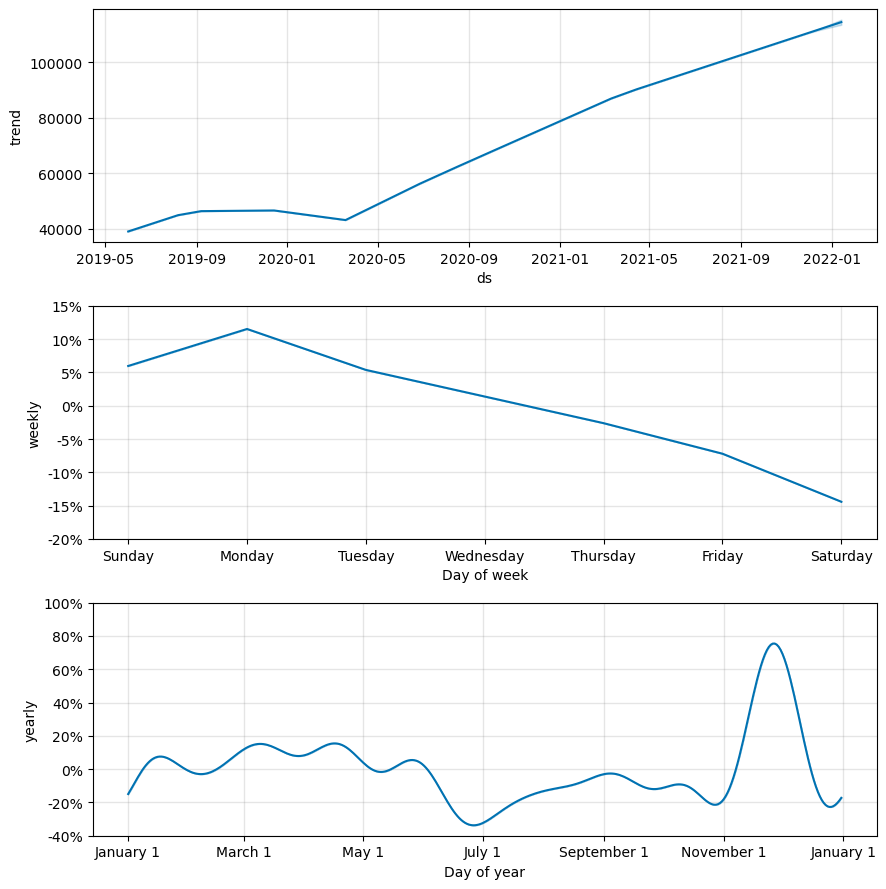

In [211]:
fig2 = m.plot_components(forecast)

In [212]:
plot_plotly(m, forecast)

##### 1.2. Sales in the Top countries

In [15]:
#Find the top countries in terms of Net Sales
df1 = dataset.groupby(['country'], as_index = False).sum().round(2).sort_values(by=['net_sales'], ascending=False).head(20)

In [16]:
df1

country          order_id  quantity   unit_price    unit_cogs  \
4       Czech Republic  1440161581367776    723535  19828409.51  12053442.87   
18            Slovakia   729161558598050    368945  10726513.89   6582573.30   
17             Romania   562967268570540    283805   8433036.25   5170098.46   
9              Hungary   580780784731316    294072   8336818.76   5097532.50   
20               Spain   243752930330663    122827   3968757.77   2441216.24   
8              Germany   249716555503977    126437   3820826.22   2350949.13   
7               France   149198109429140     75780   2567663.27   1591338.15   
11               Italy    84911058810368     43226   1710109.92   1068754.35   
3              Croatia    75552396651226     38650   1683661.69   1058920.37   
12  Multiple Countries    69748223814383     35512   1078377.09    662417.86   
10             Ireland    33960304976238     17470    883992.53    557950.97   
5              Denmark    28908381549336     14585    774340.17    488629.55   
13         Netherlands    22243276098182     11739    564059.58    355399.02   
21              Sweden    15780569983880      8047    427822.95    273403.19   
0              Austria    21887035120554     10952    359799.50    222186.73   
16            Portugal    10328905389449      5225    292902.73    184396.88   
15              Poland     9078219131275      4518    253639.02    161383.63   
1              Belgium     6980374571024      3612    182395.95    115857.02   
6              Finland     3354545548445      1666     89665.24     57011.66   
19            Slovenia     1502135428555       729     43074.86     27052.22   

    brand_id    net_sales  gross_profit  
4   38878295  20115443.05    7819799.78  
18  20962203  10899675.59    4192971.97  
17  16288244   8553066.20    3288502.88  
9   16739715   8473360.32    3267371.97  
20   7528536   4028536.38    1543859.90  
8    7505642   3882677.63    1487149.05  
7    4930566   2612078.80     989786.91  
11   3186376   1737217.47     650994.43  
3    3344321   1712780.43     633088.62  
12   2422650   1094526.92     415573.08  
10   1595402    896350.27     330947.64  
5    1359140    785021.24     289994.53  
13   1049566    573622.99     212254.30  
21    746225    436827.09     158113.69  
0     697492    364397.84     138701.85  
16    491705    297768.02     110375.87  
15    427963    257037.73      93360.75  
1     327887    184526.92      67258.04  
6     160926     90818.69      33108.62  
19     71339     43452.47      16172.89

Similarly to what it was found in the EDA section: Czech Republic, Slovakia, Romania, Hungary, Spain, and Germany are the top 6 countries but in this case in terms of the amount of net sales.

##### 1.2.1. Czech Republic

In [196]:
#Group data to work with specific info of Czech Republic
df_cz = dataset.groupby(['date','country'], as_index = False).sum().round(2)


In [197]:
df_cz = df_cz.loc[(df_cz['country'] == 'Czech Republic')] 


##### 1.2.1.1. Forecast

In [198]:
#Build the df model for Czech Republic
df_cz_model = df_cz[['date','net_sales']].rename(columns={'date': 'ds','net_sales':'y' })
df_cz_model.tail()

ds         y
16063  2022-01-10  30606.28
16083  2022-01-11  29356.35
16103  2022-01-12  30085.29
16123  2022-01-13  27248.29
16144  2022-01-14   4431.22

In [199]:
N_cz = df_cz_model.shape[0]
N_train_cz = N_cz - 60

df_cz_model_train = df_cz_model.iloc[:N_train_cz,:]
df_cz_model_test = df_cz_model.iloc[N_train_cz:,:]

In [200]:
#Creat instance and fit the model
m_cz = Prophet()
m_cz.fit(df_cz_model_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [201]:
#Configure the length of the prediction
future_cz = m_cz.make_future_dataframe(periods=60)
future_cz.tail()

ds
952 2022-01-10
953 2022-01-11
954 2022-01-12
955 2022-01-13
956 2022-01-14

In [202]:
#Forecast the future values
forecast_cz = m_cz.predict(future_cz)
forecast_cz[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
952 2022-01-10  32076.135745  26349.336609  37419.905339
953 2022-01-11  31069.004132  25513.750535  36283.575114
954 2022-01-12  30400.217106  24799.198561  36319.140203
955 2022-01-13  29879.514790  24488.056866  35592.052293
956 2022-01-14  28948.103312  23262.095073  34514.024449

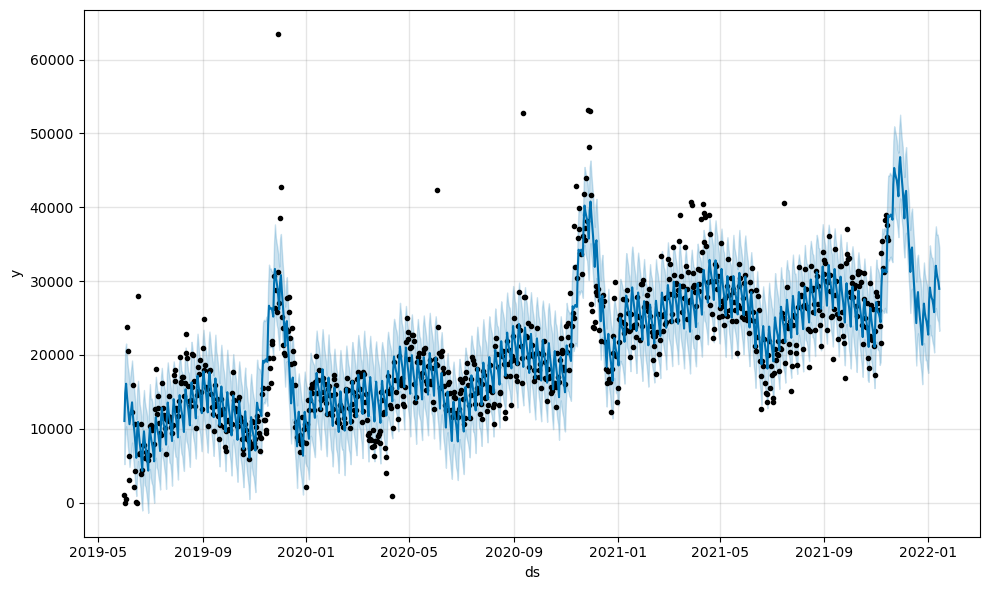

In [203]:
#Graph of historical and forecasted net sales values in Czech Republic
fig11 = m_cz.plot(forecast_cz)

##### *Metrics Calculation*

In [204]:
print ('The r2 is equals to', metrics.r2_score(list(df_cz_model_test['y']), list(forecast_cz.loc[N_train_cz:,'yhat'])))
print ('The MAE is equals to', metrics.mean_absolute_error(list(df_cz_model_test['y']), list(forecast_cz.loc[N_train_cz:,'yhat'])))

The r2 is equals to 0.5323259813507896
The MAE is equals to 5918.705943386113


##### *Plot predicted Vs true values*

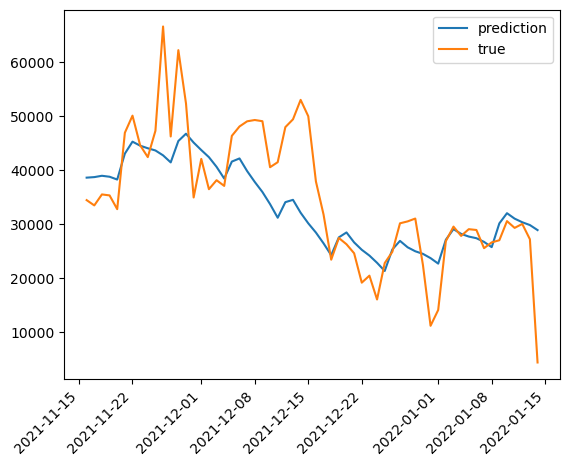

In [205]:
plt.plot(forecast_cz.loc[N_train_cz:,'ds'],forecast_cz.loc[N_train_cz:,'yhat'], label = 'prediction')
plt.plot( pd.to_datetime(df_cz_model_test['ds']),df_cz_model_test['y'], label = 'true')
plt.xticks(rotation=45, ha='right')
plt.legend()

##### *Grid search*

In [206]:
# Create the grid
changepoint_prior_scale = [0.01, 0.03, 0.05, 0.07] # default 0.05
seasonality_prior_scale = [1, 5, 10, 15] # default 10
seasonality_mode = ['additive', 'multiplicative']
changepoint_range = [0.6, 0.7, 0.8, 0.9] # default 0.8

# Compute the total number of iterations
total_iter = len(changepoint_prior_scale)*len(seasonality_prior_scale)*len(seasonality_mode)*len(changepoint_range)
print(f'Number of iterations : {total_iter}')

# Loop over the parameters, build and assess the models
grid_search_results = []
iteration = 1
for cps in changepoint_prior_scale:
    for sps in seasonality_prior_scale:
        for sm in seasonality_mode:
            for cr in changepoint_range:
                m_cz = Prophet(changepoint_prior_scale = cps, 
                                seasonality_prior_scale = sps, 
                                seasonality_mode = sm, 
                                changepoint_range = cr)
                model_cz = m_cz.fit(df_cz_model_train)
                future_cz = model_cz.make_future_dataframe(periods=60, freq='D')
                forecast_cz = model_cz.predict(future_cz) 

                r2_score = metrics.r2_score(list(df_cz_model_test['y']), list(forecast_cz.loc[N_train_cz:,'yhat']))   
                mae = metrics.mean_absolute_error(list(df_cz_model_test['y']), list(forecast_cz.loc[N_train_cz:,'yhat']))
                mse = metrics.mean_squared_error(list(df_cz_model_test['y']), list(forecast_cz.loc[N_train_cz:,'yhat']))
                
                print(f'iteration : {iteration} / {total_iter} ')
                print(f'r2_score : {r2_score}')
                print(f'mae : {mae}')
                print(f'mse : {mse}')
                
                grid_search_results.append([iteration, cps, sps, sm, cr, r2_score, mae, mse])
                iteration += 1

# Store the results in a dataframe
grid_search_df_cz = pd.DataFrame(grid_search_results, columns = ['iteration', 'cps', 'sps', 'sm', 'cr', 'r2_score', 'mae', 'mse'])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Number of iterations : 128


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 1 / 128 
r2_score : 0.5433734143740026
mae : 6367.063721254464
mse : 68586848.24519382


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 2 / 128 
r2_score : 0.5448245949559885
mae : 6333.290157956007
mse : 68368876.04321048


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 3 / 128 
r2_score : 0.5413731049813865
mae : 6401.168433410211
mse : 68887301.44059137


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 4 / 128 
r2_score : 0.5439970760198634
mae : 6353.3996114338715
mse : 68493172.16936404


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 5 / 128 
r2_score : 0.4097481571472915
mae : 7579.905625130429
mse : 88657811.10113235


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 6 / 128 
r2_score : 0.42203336224085086
mae : 7497.074843470174
mse : 86812531.99576028


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 7 / 128 
r2_score : 0.42458113727482927
mae : 7488.4079172964675
mse : 86429847.62056383


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 8 / 128 
r2_score : 0.42425828308231783
mae : 7473.92723759113
mse : 86478341.4056481


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 9 / 128 
r2_score : 0.5451008813023732
mae : 6327.703655616613
mse : 68327376.90516593


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 10 / 128 
r2_score : 0.5447921006379164
mae : 6335.2442216465715
mse : 68373756.79902408


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 11 / 128 
r2_score : 0.5447995787581605
mae : 6334.339422507978
mse : 68372633.5602235


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 12 / 128 
r2_score : 0.5440717482983282
mae : 6353.495126058982
mse : 68481956.14210585


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 13 / 128 
r2_score : 0.4254386197185054
mae : 7474.7712227836355
mse : 86301050.874845


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 14 / 128 
r2_score : 0.42696559747886165
mae : 7452.190194407261
mse : 86071693.68185598


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 15 / 128 
r2_score : 0.4220112238992486
mae : 7502.25606425633
mse : 86815857.24909347


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 16 / 128 
r2_score : 0.42494619788134325
mae : 7473.417870729286
mse : 86375014.29020716


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 17 / 128 
r2_score : 0.5434322767679192
mae : 6365.838388281194
mse : 68578006.91574435


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 18 / 128 
r2_score : 0.5444957081334361
mae : 6341.991194341417
mse : 68418275.94960733


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 19 / 128 
r2_score : 0.5439775490727732
mae : 6351.531582778678
mse : 68496105.18246254


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 20 / 128 
r2_score : 0.5453113896212158
mae : 6319.178439844303
mse : 68295757.8479903


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 21 / 128 
r2_score : 0.4160300404345477
mae : 7528.08962143038
mse : 87714251.11299369


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 22 / 128 
r2_score : 0.41536474102692833
mae : 7538.101973438402
mse : 87814181.32061717


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 23 / 128 
r2_score : 0.42023614005290466
mae : 7487.340621692991
mse : 87082480.8102792


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 24 / 128 
r2_score : 0.4180465093501089
mae : 7519.025564984238
mse : 87411370.70292482


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 25 / 128 
r2_score : 0.5439759399082421
mae : 6352.132909194528
mse : 68496346.88438478


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 26 / 128 
r2_score : 0.5442668787006483
mae : 6347.475123376538
mse : 68452646.8996893


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 27 / 128 
r2_score : 0.5431106412858508
mae : 6369.761518762732
mse : 68626317.64642301


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 28 / 128 
r2_score : 0.5440039730507154
mae : 6350.037591423679
mse : 68492136.21214367


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 29 / 128 
r2_score : 0.41223186547900237
mae : 7555.279757888285
mse : 88284749.75999549


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 30 / 128 
r2_score : 0.41936253561938475
mae : 7509.78245379113
mse : 87213699.13307138


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 31 / 128 
r2_score : 0.4241300566686427
mae : 7471.480179517183
mse : 86497601.44405279


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 32 / 128 
r2_score : 0.43256672266655305
mae : 7429.533743316052
mse : 85230385.84883994


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 33 / 128 
r2_score : 0.5426682011745474
mae : 6266.9879395078715
mse : 68692773.63853295


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 34 / 128 
r2_score : 0.5455944017434652
mae : 6007.8626435882215
mse : 68253248.47580022


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 35 / 128 
r2_score : 0.5441743803676775
mae : 5977.852332312648
mse : 68466540.46026179


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 36 / 128 
r2_score : 0.5415448368571026
mae : 5956.196271279709
mse : 68861506.73553173


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 37 / 128 
r2_score : 0.40072976690803574
mae : 7679.953447054937
mse : 90012403.6330319


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 38 / 128 
r2_score : 0.42967801749578793
mae : 7432.407828177504
mse : 85664279.07671836


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 39 / 128 
r2_score : 0.4691370829292444
mae : 7070.962717669244
mse : 79737394.79539375


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 40 / 128 
r2_score : 0.46407639296135605
mae : 7120.120385772762
mse : 80497527.4415639


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 41 / 128 
r2_score : 0.5427982145165167
mae : 6271.433269368359
mse : 68673245.1974912


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 42 / 128 
r2_score : 0.5462723538330047
mae : 6018.154907588277
mse : 68151417.79281662


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 43 / 128 
r2_score : 0.5417238506402374
mae : 5962.343840871207
mse : 68834618.26349756


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 44 / 128 
r2_score : 0.540448924586501
mae : 5947.488882019174
mse : 69026116.44280657


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 45 / 128 
r2_score : 0.38345418852330937
mae : 7799.645877694901
mse : 92607253.58334044


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 46 / 128 
r2_score : 0.4392368175628628
mae : 7353.201416517134
mse : 84228515.17193428


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 47 / 128 
r2_score : 0.4668845822387825
mae : 7090.23879813036
mse : 80075727.97154273


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 48 / 128 
r2_score : 0.47333323651939085
mae : 7019.324596301798
mse : 79107118.41955298


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 49 / 128 
r2_score : 0.5427358396694056
mae : 6282.732347782726
mse : 68682614.10921861


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 50 / 128 
r2_score : 0.5461245807600206
mae : 6016.600299239562
mse : 68173613.80516136


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 51 / 128 
r2_score : 0.5428444569331548
mae : 5969.684715149906
mse : 68666299.43105473


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 52 / 128 
r2_score : 0.5422740626822431
mae : 5961.1158856056
mse : 68751974.5650892


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 53 / 128 
r2_score : 0.3904902506341028
mae : 7750.735947473756
mse : 91550413.40051322


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 54 / 128 
r2_score : 0.44159506548109506
mae : 7339.033267663436
mse : 83874298.40667388


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 55 / 128 
r2_score : 0.45688423038826753
mae : 7195.365566855912
mse : 81577814.43860534


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 56 / 128 
r2_score : 0.4765254650178051
mae : 7000.982140553747
mse : 78627634.96747898


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 57 / 128 
r2_score : 0.5428832318451895
mae : 6269.46790205759
mse : 68660475.30891386


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 58 / 128 
r2_score : 0.5453829489388402
mae : 6005.534910175728
mse : 68285009.39791551


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 59 / 128 
r2_score : 0.5438627398495448
mae : 5976.807581334342
mse : 68513349.91375631


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 60 / 128 
r2_score : 0.5416986908162573
mae : 5956.881005114082
mse : 68838397.35364148


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 61 / 128 
r2_score : 0.3779817808953415
mae : 7840.073280924323
mse : 93429227.60616419


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 62 / 128 
r2_score : 0.4438920775051787
mae : 7313.038104015606
mse : 83529279.47857703


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 63 / 128 
r2_score : 0.45454242753435503
mae : 7214.936910159531
mse : 81929561.09992


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 64 / 128 
r2_score : 0.4634279808149473
mae : 7127.907988873509
mse : 80594921.12578207


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 65 / 128 
r2_score : 0.5419037937300826
mae : 6196.658175988255
mse : 68807590.20647135


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 66 / 128 
r2_score : 0.5400996983899671
mae : 5952.824453331475
mse : 69078571.39155224


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 67 / 128 
r2_score : 0.5337578846586137
mae : 5921.074869224858
mse : 70031133.13386802


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 68 / 128 
r2_score : 0.5347517173735568
mae : 5925.372280916037
mse : 69881856.11902349


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 69 / 128 
r2_score : 0.4401985190047223
mae : 7395.125261727998
mse : 84084064.38232557


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 70 / 128 
r2_score : 0.49328080510988515
mae : 6824.776465477219
mse : 76110926.55765948


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 71 / 128 
r2_score : 0.502421430075677
mae : 6721.709322840874
mse : 74737973.95890634


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 72 / 128 
r2_score : 0.5055359539181083
mae : 6682.4329102725615
mse : 74270162.00738794


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 73 / 128 
r2_score : 0.5416701603441378
mae : 6183.58328318666
mse : 68842682.7264674


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 74 / 128 
r2_score : 0.5388695559336689
mae : 5944.825847152896
mse : 69263342.92397279


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 75 / 128 
r2_score : 0.5325897952534144
mae : 5919.671814656123
mse : 70206584.08940403


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 76 / 128 
r2_score : 0.534247837303818
mae : 5924.029364945096
mse : 69957540.59943888


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 77 / 128 
r2_score : 0.43845781947183826
mae : 7409.003460778288
mse : 84345523.30403668


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 78 / 128 
r2_score : 0.4844154272152549
mae : 6914.013288822417
mse : 77442536.12100044


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 79 / 128 
r2_score : 0.5021218567487471
mae : 6725.497728541188
mse : 74782970.87971479


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 80 / 128 
r2_score : 0.502467861697582
mae : 6720.8662541642425
mse : 74730999.77320269


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 81 / 128 
r2_score : 0.5419503689421699
mae : 6195.075996382338
mse : 68800594.4530396


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 82 / 128 
r2_score : 0.5396869171758124
mae : 5949.6638103733885
mse : 69140572.51760335


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 83 / 128 
r2_score : 0.5323259813507896
mae : 5918.705943386113
mse : 70246209.82446608


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 84 / 128 
r2_score : 0.5369987390417134
mae : 5933.80975317494
mse : 69544345.91044411


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 85 / 128 
r2_score : 0.4405848220567242
mae : 7391.241554322326
mse : 84026040.3652439


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 86 / 128 
r2_score : 0.48335280371950207
mae : 6929.14585589484
mse : 77602145.74238299


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 87 / 128 
r2_score : 0.5001009954099906
mae : 6747.6458741915885
mse : 75086511.046514


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 88 / 128 
r2_score : 0.5044724560468715
mae : 6699.566464798218
mse : 74429902.96290766


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 89 / 128 
r2_score : 0.5417729925505655
mae : 6198.937411890021
mse : 68827236.98336133


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 90 / 128 
r2_score : 0.5391348694497959
mae : 5946.081301426169
mse : 69223491.94192132


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 91 / 128 
r2_score : 0.5311607798174633
mae : 5916.7402721366025
mse : 70421227.0119383


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 92 / 128 
r2_score : 0.5354671911503046
mae : 5928.712822800731
mse : 69774389.55248104


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 93 / 128 
r2_score : 0.43968291597769504
mae : 7397.646002022713
mse : 84161509.69033583


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 94 / 128 
r2_score : 0.49271266097714195
mae : 6829.661803389898
mse : 76196263.71638063


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 95 / 128 
r2_score : 0.5032156635983974
mae : 6713.41256658631
mse : 74618677.41374484


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 96 / 128 
r2_score : 0.4979782933088357
mae : 6770.440373854664
mse : 75405348.03819303


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 97 / 128 
r2_score : 0.540640885192595
mae : 6168.095001950812
mse : 68997283.31443937


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 98 / 128 
r2_score : 0.5367498545694116
mae : 5943.953078562676
mse : 69581729.19488196


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 99 / 128 
r2_score : 0.5285116515820671
mae : 5913.848548497889
mse : 70819134.97871622


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 100 / 128 
r2_score : 0.539506706943484
mae : 5963.903431713262
mse : 69167640.70032862


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 101 / 128 
r2_score : 0.4504172453617922
mae : 7316.3515690147615
mse : 82549177.33024849


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 102 / 128 
r2_score : 0.5019520900961485
mae : 6734.048918634809
mse : 74808470.40165547


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 103 / 128 
r2_score : 0.5192684506848287
mae : 6504.757280196651
mse : 72207494.82721172


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 104 / 128 
r2_score : 0.5130224712969975
mae : 6588.066093136148
mse : 73145661.92895527


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 105 / 128 
r2_score : 0.540662138427257
mae : 6169.673355334178
mse : 68994091.00714417


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 106 / 128 
r2_score : 0.5365853212821078
mae : 5943.899475611413
mse : 69606442.6477619


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 107 / 128 
r2_score : 0.5285876663432104
mae : 5913.901473093939
mse : 70807717.30604659


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 108 / 128 
r2_score : 0.5384817722018918
mae : 5955.681426506855
mse : 69321589.34413445


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 109 / 128 
r2_score : 0.45240407897166823
mae : 7298.5715429396705
mse : 82250748.24272129


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 110 / 128 
r2_score : 0.5049287718439727
mae : 6699.628492412311
mse : 74361362.79614371


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 111 / 128 
r2_score : 0.51190584253849
mae : 6604.48602942569
mse : 73313383.3223581


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 112 / 128 
r2_score : 0.519483603320412
mae : 6488.498390921181
mse : 72175178.17804845


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 113 / 128 
r2_score : 0.5403239304041059
mae : 6160.038350034686
mse : 69044890.9892069


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 114 / 128 
r2_score : 0.5362013692477814
mae : 5942.941358914136
mse : 69664113.53408508


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 115 / 128 
r2_score : 0.5284026068245387
mae : 5913.806352854473
mse : 70835513.86788294


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 116 / 128 
r2_score : 0.5383288265214392
mae : 5954.928880016095
mse : 69344562.29951018


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 117 / 128 
r2_score : 0.4501411585820817
mae : 7318.711989174398
mse : 82590646.49270767


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 118 / 128 
r2_score : 0.4992032610842516
mae : 6763.443754006162
mse : 75221353.76023719


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 119 / 128 
r2_score : 0.5130555936470748
mae : 6589.598815676492
mse : 73140686.84062317


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 120 / 128 
r2_score : 0.5186535175350787
mae : 6501.743406074023
mse : 72299859.8535823


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 121 / 128 
r2_score : 0.5409015801111461
mae : 6186.7946275669765
mse : 68958126.06127058


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 122 / 128 
r2_score : 0.5380332668982637
mae : 5950.351235068931
mse : 69388956.34852149


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 123 / 128 
r2_score : 0.52902250273468
mae : 5913.984243427786
mse : 70742403.41821782


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 124 / 128 
r2_score : 0.5370995763707445
mae : 5946.294905894342
mse : 69529199.80462937


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 125 / 128 
r2_score : 0.44811632213037833
mae : 7334.994790772692
mse : 82894783.734835


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 126 / 128 
r2_score : 0.49729483554923914
mae : 6784.870498644749
mse : 75508005.69132811


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 127 / 128 
r2_score : 0.5136058216815651
mae : 6580.757479812129
mse : 73058040.74008983
iteration : 128 / 128 
r2_score : 0.5115358610026738
mae : 6610.661703056016
mse : 73368955.79283912


In [207]:
grid_search_df_cz

iteration   cps  sps              sm   cr  r2_score          mae  \
0            1  0.01    1        additive  0.6  0.543373  6367.063721   
1            2  0.01    1        additive  0.7  0.544825  6333.290158   
2            3  0.01    1        additive  0.8  0.541373  6401.168433   
3            4  0.01    1        additive  0.9  0.543997  6353.399611   
4            5  0.01    1  multiplicative  0.6  0.409748  7579.905625   
..         ...   ...  ...             ...  ...       ...          ...   
123        124  0.07   15        additive  0.9  0.537100  5946.294906   
124        125  0.07   15  multiplicative  0.6  0.448116  7334.994791   
125        126  0.07   15  multiplicative  0.7  0.497295  6784.870499   
126        127  0.07   15  multiplicative  0.8  0.513606  6580.757480   
127        128  0.07   15  multiplicative  0.9  0.511536  6610.661703   

              mse  
0    6.858685e+07  
1    6.836888e+07  
2    6.888730e+07  
3    6.849317e+07  
4    8.865781e+07  
..            ...  
123  6.952920e+07  
124  8.289478e+07  
125  7.550801e+07  
126  7.305804e+07  
127  7.336896e+07  

[128 rows x 8 columns]

##### 1.2.1.2. Analysis of trend and yearly and weekly seasonal components

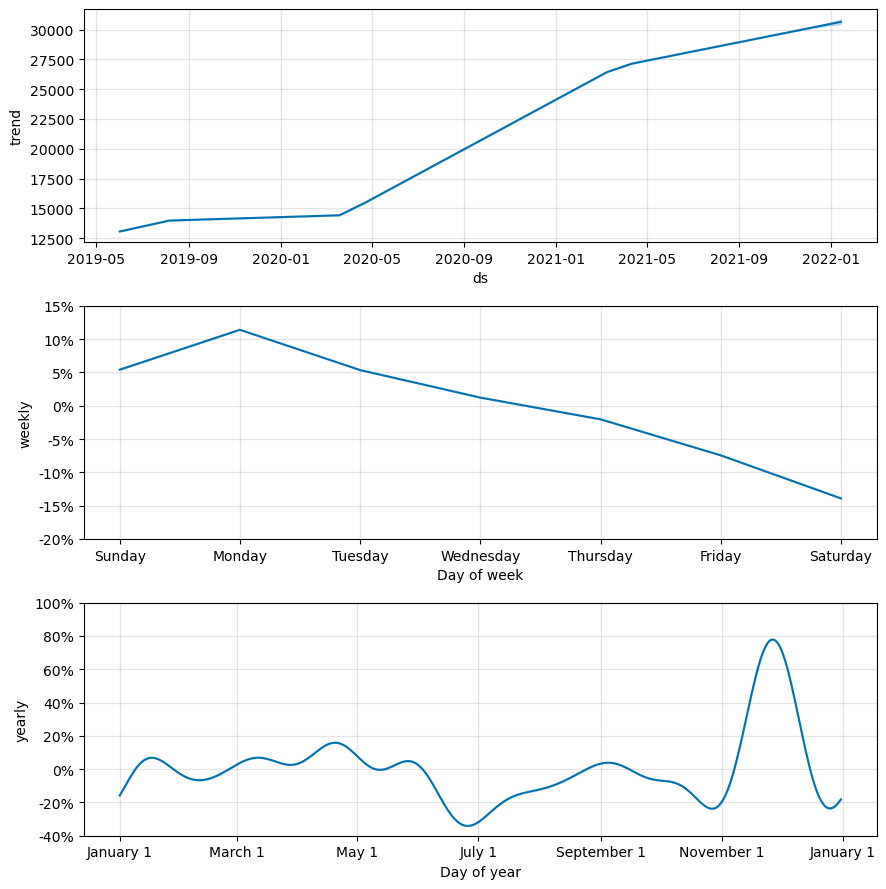

In [210]:
#Graphs of trend and yearly and weekly seasonal components
fig12 = m_cz.plot_components(forecast_cz)

In [209]:
plot_plotly(m_cz, forecast_cz)

##### 1.2.2. Slovakia

In [213]:
#Group data to work with specific info of Slovakia
df_sk = dataset.groupby(['date','country'], as_index = False).sum().round(2)

In [214]:
df_sk = df_sk.loc[(df_sk['country'] == 'Slovakia')] 

##### 1.2.2.1. Forecast

In [215]:
#Build the df model for Slovakia
df_sk_model = df_sk[['date','net_sales']].rename(columns={'date': 'ds','net_sales':'y' })
df_sk_model.tail()

ds         y
16076  2022-01-10  14893.69
16096  2022-01-11  16599.22
16116  2022-01-12  16595.02
16137  2022-01-13  15489.17
16157  2022-01-14   2277.78

In [216]:
N_sk = df_sk_model.shape[0]
N_train_sk = N_sk - 60

df_sk_model_train = df_sk_model.iloc[:N_train_sk,:]
df_sk_model_test = df_sk_model.iloc[N_train_sk:,:]

In [217]:
#Creat instance and fit the model
m_sk = Prophet()
m_sk.fit(df_sk_model_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [218]:
#Configure the length of the prediction
future_sk = m_sk.make_future_dataframe(periods=60)
future_sk.tail()

ds
952 2022-01-10
953 2022-01-11
954 2022-01-12
955 2022-01-13
956 2022-01-14

In [219]:
#Forecast the future values
forecast_sk = m_sk.predict(future_sk)
forecast_sk[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
952 2022-01-10  17535.752461  14487.171218  20483.569076
953 2022-01-11  16966.711205  13960.435595  20052.437317
954 2022-01-12  16593.394755  13760.044024  19467.663833
955 2022-01-13  16004.624569  13026.039691  19205.193683
956 2022-01-14  15657.685509  12541.517125  18771.154918

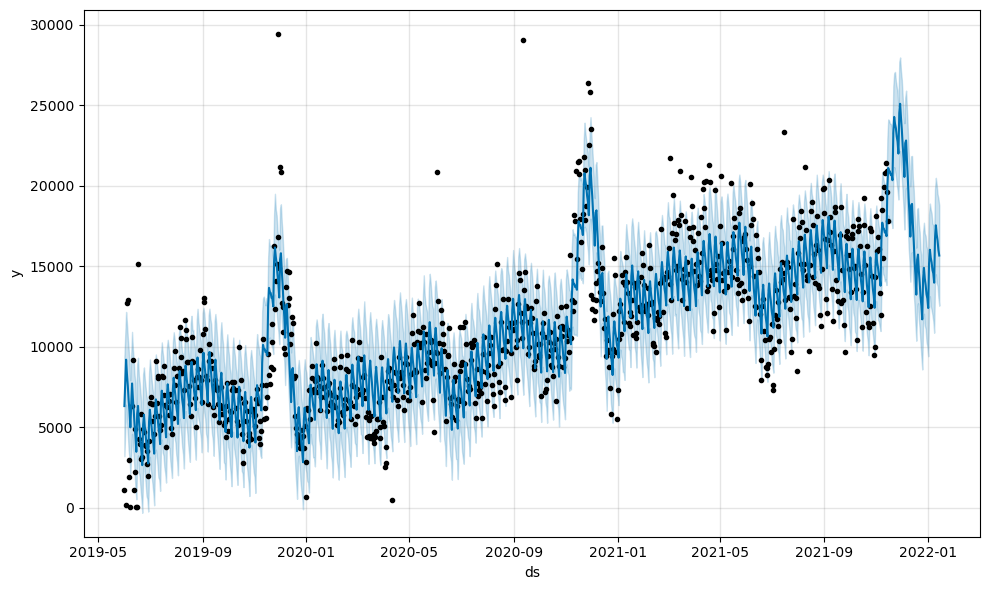

In [220]:
#Graph of historical and forecasted net sales values in Slovakia
fig21 = m_sk.plot(forecast_sk)

##### *Metrics Calculation*

In [221]:
print ('The r2 is equals to', metrics.r2_score(list(df_sk_model_test['y']), list(forecast_sk.loc[N_train_sk:,'yhat'])))
print ('The MAE is equals to', metrics.mean_absolute_error(list(df_sk_model_test['y']), list(forecast_sk.loc[N_train_sk:,'yhat'])))

The r2 is equals to 0.5168666152339256
The MAE is equals to 3167.253519415191


##### *Plot predicted Vs true values*

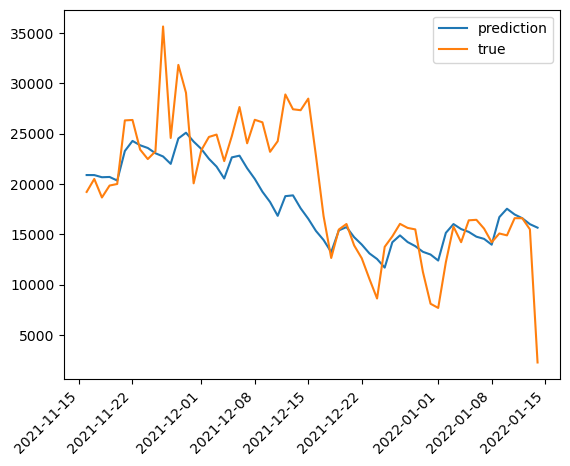

In [222]:
plt.plot(forecast_sk.loc[N_train_sk:,'ds'],forecast_sk.loc[N_train_sk:,'yhat'], label = 'prediction')
plt.plot( pd.to_datetime(df_sk_model_test['ds']),df_sk_model_test['y'], label = 'true')
plt.xticks(rotation=45, ha='right')
plt.legend()

##### *Grid Search*

In [223]:
# Create the grid
changepoint_prior_scale = [0.01, 0.03, 0.05, 0.07] # default 0.05
seasonality_prior_scale = [1, 5, 10, 15] # default 10
seasonality_mode = ['additive', 'multiplicative']
changepoint_range = [0.6, 0.7, 0.8, 0.9] # default 0.8

# Compute the total number of iterations
total_iter = len(changepoint_prior_scale)*len(seasonality_prior_scale)*len(seasonality_mode)*len(changepoint_range)
print(f'Number of iterations : {total_iter}')

# Loop over the parameters, build and assess the models
grid_search_results = []
iteration = 1
for cps in changepoint_prior_scale:
    for sps in seasonality_prior_scale:
        for sm in seasonality_mode:
            for cr in changepoint_range:
                m_sk = Prophet(changepoint_prior_scale = cps, 
                                seasonality_prior_scale = sps, 
                                seasonality_mode = sm, 
                                changepoint_range = cr)
                model_sk = m_sk.fit(df_sk_model_train)
                future_sk = model_sk.make_future_dataframe(periods=60, freq='D')
                forecast_sk = model_sk.predict(future_sk) 

                r2_score = metrics.r2_score(list(df_sk_model_test['y']), list(forecast_sk.loc[N_train_sk:,'yhat']))   
                mae = metrics.mean_absolute_error(list(df_sk_model_test['y']), list(forecast_sk.loc[N_train_sk:,'yhat']))
                mse = metrics.mean_squared_error(list(df_sk_model_test['y']), list(forecast_sk.loc[N_train_sk:,'yhat']))
                
                print(f'iteration : {iteration} / {total_iter} ')
                print(f'r2_score : {r2_score}')
                print(f'mae : {mae}')
                print(f'mse : {mse}')
                
                grid_search_results.append([iteration, cps, sps, sm, cr, r2_score, mae, mse])
                iteration += 1

# Store the results in a dataframe
grid_search_df_sk = pd.DataFrame(grid_search_results, columns = ['iteration', 'cps', 'sps', 'sm', 'cr', 'r2_score', 'mae', 'mse'])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Number of iterations : 128


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 1 / 128 
r2_score : 0.5502396708554893
mae : 3160.582953239379
mse : 19529196.71867094


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 2 / 128 
r2_score : 0.5508993272262716
mae : 3173.501927520627
mse : 19500553.55430774


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 3 / 128 
r2_score : 0.5483088089362859
mae : 3153.62252161544
mse : 19613037.332911946


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 4 / 128 
r2_score : 0.5492554305210036
mae : 3153.2414288686705
mse : 19571933.7540764


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 5 / 128 
r2_score : 0.5116580011745937
mae : 3577.8857045437267
mse : 21204464.56269392


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 6 / 128 
r2_score : 0.5265494514127637
mae : 3489.9007186133244
mse : 20557857.820652697


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 7 / 128 
r2_score : 0.5285973193533584
mae : 3477.412992841952
mse : 20468936.648032147


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 8 / 128 
r2_score : 0.5305414267307343
mae : 3464.637930732739
mse : 20384520.89823222


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 9 / 128 
r2_score : 0.5489531323954714
mae : 3155.807304562413
mse : 19585059.944135074


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 10 / 128 
r2_score : 0.5490284968504084
mae : 3154.47609560122
mse : 19581787.518421452


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 11 / 128 
r2_score : 0.5473292609587537
mae : 3151.242971574401
mse : 19655570.61988501


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 12 / 128 
r2_score : 0.5485722918328256
mae : 3151.710397781624
mse : 19601596.552155852


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 13 / 128 
r2_score : 0.5241131132701478
mae : 3508.5442611890658
mse : 20663646.89046872


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 14 / 128 
r2_score : 0.531929896488732
mae : 3463.4142430357597
mse : 20324231.67909758


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 15 / 128 
r2_score : 0.5208185111782754
mae : 3521.2435021903284
mse : 20806702.932081603


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 16 / 128 
r2_score : 0.5318641769287638
mae : 3453.174972668253
mse : 20327085.310535744


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 17 / 128 
r2_score : 0.5494605383271929
mae : 3158.08884291786
mse : 19563027.698037114


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 18 / 128 
r2_score : 0.5480715655003168
mae : 3153.303553491586
mse : 19623338.761097185


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 19 / 128 
r2_score : 0.5507270844287346
mae : 3169.821889168282
mse : 19508032.56759215


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 20 / 128 
r2_score : 0.5485977090551258
mae : 3152.4102843638834
mse : 19600492.90227351


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 21 / 128 
r2_score : 0.5044593453026489
mae : 3613.037830266713
mse : 21517039.85562967


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 22 / 128 
r2_score : 0.53259952411836
mae : 3458.460186158875
mse : 20295155.54930166


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 23 / 128 
r2_score : 0.5242126125588724
mae : 3499.534399210462
mse : 20659326.49790193


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 24 / 128 
r2_score : 0.5310216751989545
mae : 3459.7803973454584
mse : 20363667.86562361


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 25 / 128 
r2_score : 0.5488877174787518
mae : 3155.4030363868033
mse : 19587900.347554788


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 26 / 128 
r2_score : 0.5485086728714552
mae : 3153.691876615684
mse : 19604358.972785532


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 27 / 128 
r2_score : 0.5474742672341726
mae : 3151.7078749066613
mse : 19649274.25292111


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 28 / 128 
r2_score : 0.5479795529247306
mae : 3152.4813407396664
mse : 19627334.070538178


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 29 / 128 
r2_score : 0.5194953038500001
mae : 3529.9343476576137
mse : 20864158.36898647


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 30 / 128 
r2_score : 0.531916916605103
mae : 3462.1377963767864
mse : 20324795.28305362


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 31 / 128 
r2_score : 0.527993615996142
mae : 3483.060378232476
mse : 20495150.257501055


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 32 / 128 
r2_score : 0.5155212571490122
mae : 3562.1649511740407
mse : 21036716.806811344


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 33 / 128 
r2_score : 0.5468307200963667
mae : 3196.5598063722796
mse : 19677217.93278246


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 34 / 128 
r2_score : 0.5426401749660237
mae : 3147.7372982911315
mse : 19859177.022781793


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 35 / 128 
r2_score : 0.5284323541884218
mae : 3144.011404943059
mse : 20476099.65674815


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 36 / 128 
r2_score : 0.5409264347847106
mae : 3143.150290995405
mse : 19933589.919955745


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 37 / 128 
r2_score : 0.4740816647292978
mae : 3777.0109273556063
mse : 22836079.489254866


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 38 / 128 
r2_score : 0.519440125825938
mae : 3528.5433799789575
mse : 20866554.27279707


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 39 / 128 
r2_score : 0.5261219714066113
mae : 3490.378121028715
mse : 20576419.575864248


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 40 / 128 
r2_score : 0.5303133390095173
mae : 3466.1115084054923
mse : 20394424.773003113


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 41 / 128 
r2_score : 0.5462315088237037
mae : 3192.6420672066006
mse : 19703236.48991518


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 42 / 128 
r2_score : 0.5432772340323022
mae : 3150.0081335955606
mse : 19831515.06368809


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 43 / 128 
r2_score : 0.53832562564853
mae : 3143.015828153628
mse : 20046520.54090401


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 44 / 128 
r2_score : 0.5320858203246276
mae : 3141.1947770037445
mse : 20317461.25701494


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 45 / 128 
r2_score : 0.4700866699150549
mae : 3794.392882391382
mse : 23009547.522253282


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 46 / 128 
r2_score : 0.505041954899289
mae : 3612.7982169488814
mse : 21491742.165536344


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 47 / 128 
r2_score : 0.5322509243619877
mae : 3451.539687070313
mse : 20310292.218272053


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 48 / 128 
r2_score : 0.5300369130783114
mae : 3465.1952444745807
mse : 20406427.55768386


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 49 / 128 
r2_score : 0.5455896723818554
mae : 3188.361014940344
mse : 19731105.889063638


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 50 / 128 
r2_score : 0.5400742521952783
mae : 3145.425192110025
mse : 19970592.8309526


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 51 / 128 
r2_score : 0.5377268068284077
mae : 3143.226562500998
mse : 20072522.057221062


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 52 / 128 
r2_score : 0.5293771586479011
mae : 3143.264747320448
mse : 20435074.979927618


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 53 / 128 
r2_score : 0.47601446867272845
mae : 3765.8366865599182
mse : 22752154.54971723


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 54 / 128 
r2_score : 0.5191049471051516
mae : 3531.394971346888
mse : 20881108.182401773


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 55 / 128 
r2_score : 0.5238744393300264
mae : 3504.112579431642
mse : 20674010.433062874


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 56 / 128 
r2_score : 0.5250012119514222
mae : 3496.380567223928
mse : 20625084.454592723


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 57 / 128 
r2_score : 0.5447311572264624
mae : 3186.3839105675493
mse : 19768383.76856786


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 58 / 128 
r2_score : 0.5397383469189476
mae : 3144.7833311372938
mse : 19985178.288573503


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 59 / 128 
r2_score : 0.5362046031041874
mae : 3142.6018031754274
mse : 20138618.184535664


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 60 / 128 
r2_score : 0.531674730348068
mae : 3141.6481119450486
mse : 20335311.33515895


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 61 / 128 
r2_score : 0.47162298351289245
mae : 3787.361849668575
mse : 22942838.72530179


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 62 / 128 
r2_score : 0.5214644704715548
mae : 3518.761337686168
mse : 20778654.513194367


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 63 / 128 
r2_score : 0.5268582781245099
mae : 3487.4320144376234
mse : 20544448.15062434


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 64 / 128 
r2_score : 0.5270900514206123
mae : 3485.7165888239197
mse : 20534384.243248764


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 65 / 128 
r2_score : 0.5411535385221518
mae : 3177.2736165871893
mse : 19923728.771080144


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 66 / 128 
r2_score : 0.5282546262260938
mae : 3145.712760892019
mse : 20483816.8432446


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 67 / 128 
r2_score : 0.5186941844844759
mae : 3162.926602998224
mse : 20898944.04631425


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 68 / 128 
r2_score : 0.5181415917814258
mae : 3164.05683876544
mse : 20922938.36262866


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 69 / 128 
r2_score : 0.5131039059859368
mae : 3565.5143031059874
mse : 21141681.43651002


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 70 / 128 
r2_score : 0.5383746781457219
mae : 3404.2777307317792
mse : 20044390.615685787


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 71 / 128 
r2_score : 0.5452337905932116
mae : 3349.475765264823
mse : 19746558.75364206


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 72 / 128 
r2_score : 0.546452042534201
mae : 3321.0435340644535
mse : 19693660.62042133


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 73 / 128 
r2_score : 0.5416919970982459
mae : 3179.1689776636763
mse : 19900348.177515127


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 74 / 128 
r2_score : 0.5308522859064209
mae : 3144.1529220298207
mse : 20371022.975893598


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 75 / 128 
r2_score : 0.5182915406632425
mae : 3163.8644362741134
mse : 20916427.381065857


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 76 / 128 
r2_score : 0.5152353216803525
mae : 3171.9479891628816
mse : 21049132.50836271


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 77 / 128 
r2_score : 0.5136791892769599
mae : 3563.4891022340107
mse : 21116701.864432767


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 78 / 128 
r2_score : 0.5404999793527437
mae : 3389.745382716067
mse : 19952107.186781988


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 79 / 128 
r2_score : 0.5456427461246043
mae : 3343.7672335295433
mse : 19728801.355969954


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 80 / 128 
r2_score : 0.5448615761131116
mae : 3347.5140364247145
mse : 19762720.805589233


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 81 / 128 
r2_score : 0.5418561757937435
mae : 3178.162281818582
mse : 19893219.31835699


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 82 / 128 
r2_score : 0.5300096518301503
mae : 3144.23185136791
mse : 20407611.277642325


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 83 / 128 
r2_score : 0.5168666152339256
mae : 3167.253519415191
mse : 20978299.55434423


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 84 / 128 
r2_score : 0.5144965928041365
mae : 3174.087339119661
mse : 21081209.106965404


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 85 / 128 
r2_score : 0.5092588778718347
mae : 3587.50511329835
mse : 21308637.7142501


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 86 / 128 
r2_score : 0.5392247059852775
mae : 3399.4796583308844
mse : 20007481.266818576


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 87 / 128 
r2_score : 0.5436439007372291
mae : 3362.1898619888157
mse : 19815593.903579712


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 88 / 128 
r2_score : 0.5456458059260332
mae : 3334.315050101393
mse : 19728668.49528804


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 89 / 128 
r2_score : 0.5409052470706428
mae : 3178.1738133102454
mse : 19934509.918917943


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 90 / 128 
r2_score : 0.5299519587719644
mae : 3144.365098577805
mse : 20410116.387607794


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 91 / 128 
r2_score : 0.5176486070381832
mae : 3165.3666315599753
mse : 20944344.421380896


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 92 / 128 
r2_score : 0.5155882300362925
mae : 3170.914459146749
mse : 21033808.754220307


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 93 / 128 
r2_score : 0.5068028532832716
mae : 3603.6971688685894
mse : 21415281.595952995


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 94 / 128 
r2_score : 0.5366058022662235
mae : 3420.142524650912
mse : 20121197.57882401


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 95 / 128 
r2_score : 0.5433329943987326
mae : 3365.5032066327244
mse : 19829093.8737908


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 96 / 128 
r2_score : 0.5462182476582546
mae : 3304.7778953397215
mse : 19703812.307505116


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 97 / 128 
r2_score : 0.537441026854973
mae : 3175.25027859159
mse : 20084931.006961204


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 98 / 128 
r2_score : 0.5240652321498296
mae : 3152.2028986798005
mse : 20665725.952932015


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 99 / 128 
r2_score : 0.5061108720546084
mae : 3198.1694627359825
mse : 21445328.3490001


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 100 / 128 
r2_score : 0.5025412010405437
mae : 3209.0001261586217
mse : 21600328.25214231


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 101 / 128 
r2_score : 0.5222214302595949
mae : 3509.693800616976
mse : 20745786.303948615


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 102 / 128 
r2_score : 0.5443943965967801
mae : 3347.826218176318
mse : 19783006.366778504


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 103 / 128 
r2_score : 0.5475634165250702
mae : 3293.2528684916383
mse : 19645403.271141585


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 104 / 128 
r2_score : 0.5472249498340306
mae : 3272.428747114421
mse : 19660099.948824573


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 105 / 128 
r2_score : 0.5378855839510457
mae : 3175.816784452647
mse : 20065627.74160118


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 106 / 128 
r2_score : 0.5212875882756093
mae : 3157.3032805317944
mse : 20786334.975380126


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 107 / 128 
r2_score : 0.5045665781378652
mae : 3202.811718862297
mse : 21512383.66210183


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 108 / 128 
r2_score : 0.5082703239912454
mae : 3191.285941556113
mse : 21351562.049612787


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 109 / 128 
r2_score : 0.5227403798794796
mae : 3505.9345122446994
mse : 20723252.815427996


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 110 / 128 
r2_score : 0.5445528938848203
mae : 3348.8115424212388
mse : 19776124.201952193


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 111 / 128 
r2_score : 0.5472825927607402
mae : 3278.232357447146
mse : 19657597.015635036


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 112 / 128 
r2_score : 0.5473931644678005
mae : 3292.0050751135805
mse : 19652795.843813576


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 113 / 128 
r2_score : 0.5377604933335253
mae : 3175.637870200468
mse : 20071059.343987867


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 114 / 128 
r2_score : 0.5200905148963901
mae : 3159.794441431587
mse : 20838313.507043697


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 115 / 128 
r2_score : 0.5061451784650569
mae : 3197.7845367729196
mse : 21443838.718646005


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 116 / 128 
r2_score : 0.5060683631274959
mae : 3197.949989671448
mse : 21447174.143629115


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 117 / 128 
r2_score : 0.5245376312393701
mae : 3494.793500134786
mse : 20645213.75087341


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 118 / 128 
r2_score : 0.5437380236436424
mae : 3358.339079547395
mse : 19811506.960743792


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 119 / 128 
r2_score : 0.5474599033620413
mae : 3280.0060920849814
mse : 19649897.95151415


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 120 / 128 
r2_score : 0.5472969368194198
mae : 3278.70316536333
mse : 19656974.177368637


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 121 / 128 
r2_score : 0.538051762796347
mae : 3175.553569823736
mse : 20058412.03325593


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 122 / 128 
r2_score : 0.5228903273103611
mae : 3154.540780148263
mse : 20716741.89686674


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 123 / 128 
r2_score : 0.5095508805824253
mae : 3187.9890214475327
mse : 21295958.564916596


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 124 / 128 
r2_score : 0.5003757869550233
mae : 3216.3267811842543
mse : 21694353.436030686


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 125 / 128 
r2_score : 0.5226522771063158
mae : 3506.563908204269
mse : 20727078.356003907


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 126 / 128 
r2_score : 0.544542712301177
mae : 3346.7771906892617
mse : 19776566.299969714


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 127 / 128 
r2_score : 0.5474399105301663
mae : 3293.7662063034845
mse : 19650766.067088936
iteration : 128 / 128 
r2_score : 0.5476334860594861
mae : 3274.08449378176
mse : 19642360.757978637


##### 1.2.2.2. Analysis of trend and yearly and weekly seasonal components

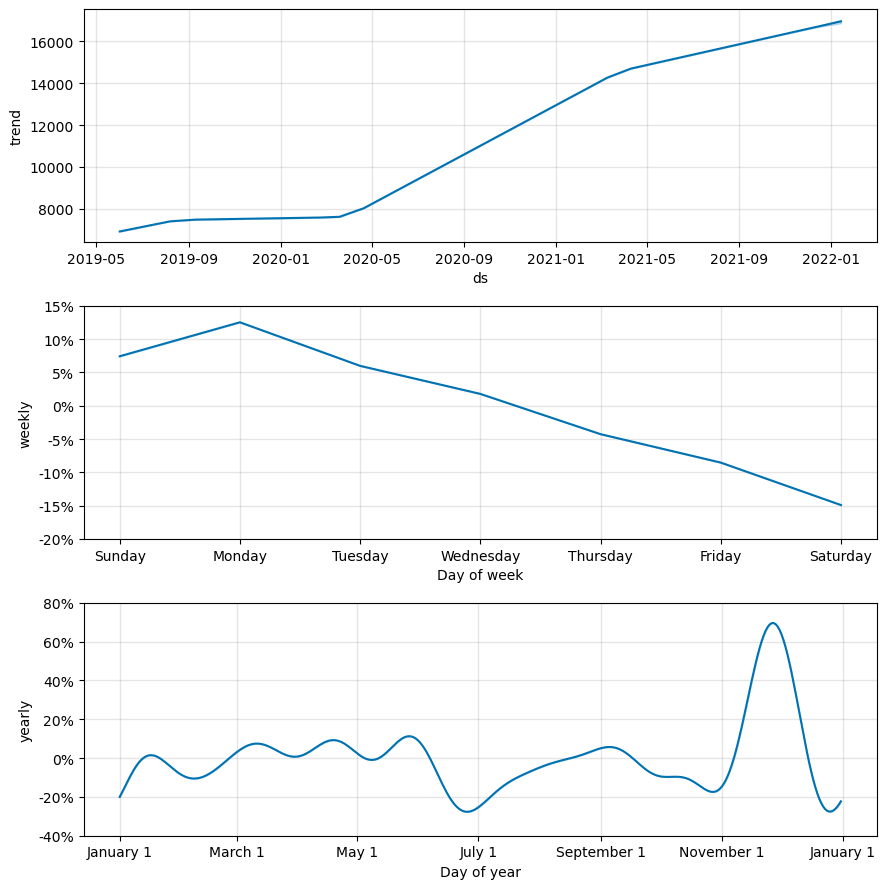

In [225]:
#Graphs of trend and yearly and weekly seasonal components
fig22 = m_sk.plot_components(forecast_sk)

In [226]:
plot_plotly(m_sk, forecast_sk)

##### 1.2.3. Romania

In [227]:
#Group data to work with specific info of Romania
df_ro = dataset.groupby(['date','country'], as_index = False).sum().round(2)

In [228]:
df_ro = df_ro.loc[(df_ro['country'] == 'Romania')] 

##### 1.2.3.1. Forecast

In [229]:
#Build the df model for Romania
df_ro_model = df_ro[['date','net_sales']].rename(columns={'date': 'ds','net_sales':'y' })
df_ro_model.tail()

ds         y
16075  2022-01-10  17484.22
16095  2022-01-11  17621.39
16115  2022-01-12  15109.37
16136  2022-01-13  15638.70
16156  2022-01-14   2007.60

In [230]:
N_ro = df_ro_model.shape[0]
N_train_ro = N_ro - 60

df_ro_model_train = df_ro_model.iloc[:N_train_ro,:]
df_ro_model_test = df_ro_model.iloc[N_train_ro:,:]

In [231]:
#Creat instance and fit the model
m_ro = Prophet()
m_ro.fit(df_ro_model_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [232]:
#Configure the length of the prediction
future_ro = m_ro.make_future_dataframe(periods=60)
future_ro.tail()

ds
950 2022-01-10
951 2022-01-11
952 2022-01-12
953 2022-01-13
954 2022-01-14

In [233]:
#Forecast the future values
forecast_ro = m_ro.predict(future_ro)
forecast_ro[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
950 2022-01-10  15262.619513  12619.890643  17876.992352
951 2022-01-11  14790.015292  12260.277794  17182.069922
952 2022-01-12  14572.250637  12110.493962  16991.266053
953 2022-01-13  14309.621688  11868.772184  17050.254145
954 2022-01-14  14234.307087  11769.743873  16860.085215

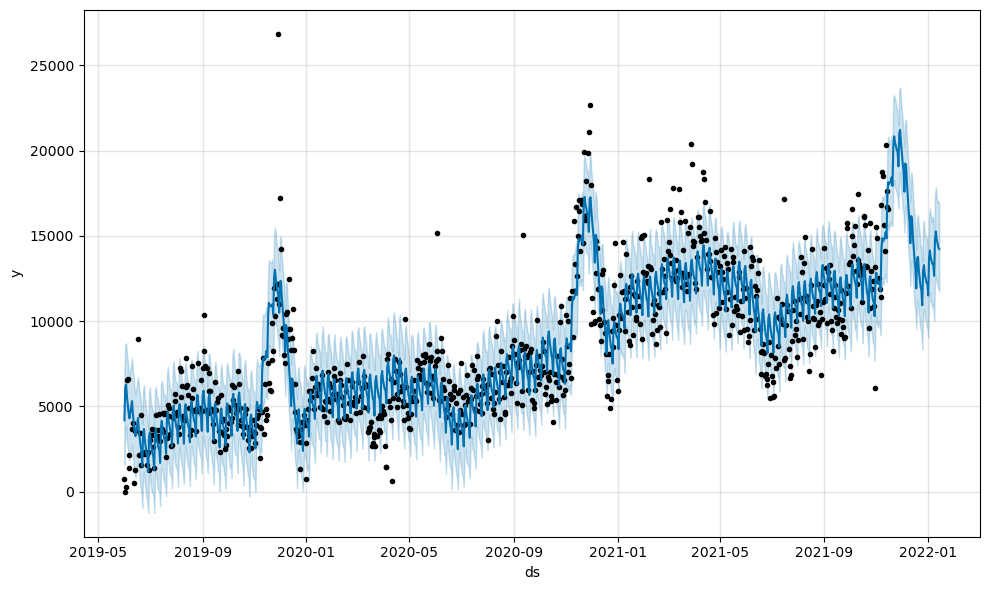

In [234]:
#Graph of historical and forecasted net sales values in Romania
fig31 = m_ro.plot(forecast_ro)

##### *Metrics Calculation*

In [235]:
print ('The r2 is equals to', metrics.r2_score(list(df_ro_model_test['y']), list(forecast_ro.loc[N_train_ro:,'yhat'])))
print ('The MAE is equals to', metrics.mean_absolute_error(list(df_ro_model_test['y']), list(forecast_ro.loc[N_train_ro:,'yhat'])))

The r2 is equals to 0.31872048313129997
The MAE is equals to 3619.9417428197476


##### *Plot predicted Vs true values*

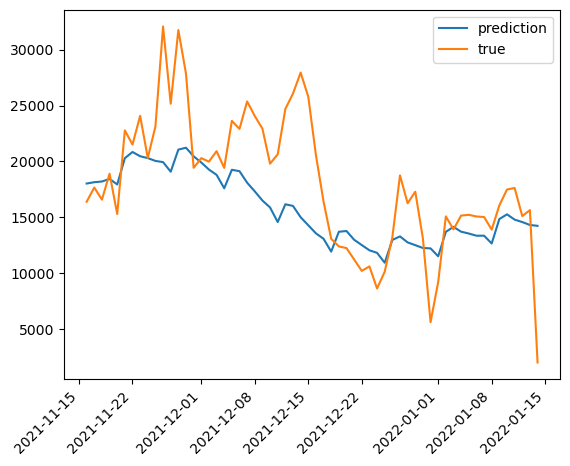

In [236]:
plt.plot(forecast_ro.loc[N_train_ro:,'ds'],forecast_ro.loc[N_train_ro:,'yhat'], label = 'prediction')
plt.plot( pd.to_datetime(df_ro_model_test['ds']),df_ro_model_test['y'], label = 'true')
plt.xticks(rotation=45, ha='right')
plt.legend()

##### *Grid Search*

In [237]:
# Create the grid
changepoint_prior_scale = [0.01, 0.03, 0.05, 0.07] # default 0.05
seasonality_prior_scale = [1, 5, 10, 15] # default 10
seasonality_mode = ['additive', 'multiplicative']
changepoint_range = [0.6, 0.7, 0.8, 0.9] # default 0.8

# Compute the total number of iterations
total_iter = len(changepoint_prior_scale)*len(seasonality_prior_scale)*len(seasonality_mode)*len(changepoint_range)
print(f'Number of iterations : {total_iter}')

# Loop over the parameters, build and assess the models
grid_search_results = []
iteration = 1
for cps in changepoint_prior_scale:
    for sps in seasonality_prior_scale:
        for sm in seasonality_mode:
            for cr in changepoint_range:
                m_ro = Prophet(changepoint_prior_scale = cps, 
                                seasonality_prior_scale = sps, 
                                seasonality_mode = sm, 
                                changepoint_range = cr)
                model_ro = m_ro.fit(df_ro_model_train)
                future_ro = model_ro.make_future_dataframe(periods=60, freq='D')
                forecast_ro = model_ro.predict(future_ro) 

                r2_score = metrics.r2_score(list(df_ro_model_test['y']), list(forecast_ro.loc[N_train_ro:,'yhat']))   
                mae = metrics.mean_absolute_error(list(df_ro_model_test['y']), list(forecast_ro.loc[N_train_ro:,'yhat']))
                mse = metrics.mean_squared_error(list(df_ro_model_test['y']), list(forecast_ro.loc[N_train_ro:,'yhat']))
                
                print(f'iteration : {iteration} / {total_iter} ')
                print(f'r2_score : {r2_score}')
                print(f'mae : {mae}')
                print(f'mse : {mse}')
                
                grid_search_results.append([iteration, cps, sps, sm, cr, r2_score, mae, mse])
                iteration += 1

# Store the results in a dataframe
grid_search_df_ro = pd.DataFrame(grid_search_results, columns = ['iteration', 'cps', 'sps', 'sm', 'cr', 'r2_score', 'mae', 'mse'])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Number of iterations : 128


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 1 / 128 
r2_score : 0.4078411410118028
mae : 3283.344420138451
mse : 21360506.38078396


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 2 / 128 
r2_score : 0.41267333907870984
mae : 3266.083774090886
mse : 21186198.09158983


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 3 / 128 
r2_score : 0.404406509606435
mae : 3294.4792974374727
mse : 21484401.286578935


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 4 / 128 
r2_score : 0.4074667717251472
mae : 3283.874834816715
mse : 21374010.7258005


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 5 / 128 
r2_score : 0.4051544878902186
mae : 3540.2855871406437
mse : 21457420.02190488


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 6 / 128 
r2_score : 0.41767849197735907
mae : 3481.1865456766445
mse : 21005650.931304038


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 7 / 128 
r2_score : 0.4046499825404357
mae : 3520.003962906386
mse : 21475618.668399148


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 8 / 128 
r2_score : 0.41001147472780153
mae : 3512.391909931914
mse : 21282217.54581114


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 9 / 128 
r2_score : 0.4073681325782029
mae : 3285.257086854742
mse : 21377568.862431772


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 10 / 128 
r2_score : 0.4213874291574641
mae : 3239.7355829694197
mse : 20871861.19718281


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 11 / 128 
r2_score : 0.404533912965903
mae : 3293.6289140194813
mse : 21479805.559889138


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 12 / 128 
r2_score : 0.4146676660280788
mae : 3260.8831523024587
mse : 21114258.21788744


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 13 / 128 
r2_score : 0.41283091783609527
mae : 3497.446136398709
mse : 21180513.870199718


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 14 / 128 
r2_score : 0.41026114789563783
mae : 3503.894316432442
mse : 21273211.27120471


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 15 / 128 
r2_score : 0.41429968674837925
mae : 3514.025720136588
mse : 21127532.060932614


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 16 / 128 
r2_score : 0.4165403622557359
mae : 3477.2419822706793
mse : 21046705.838803746


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 17 / 128 
r2_score : 0.41846874063195094
mae : 3247.2301957988648
mse : 20977144.87896251


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 18 / 128 
r2_score : 0.40706231568924023
mae : 3285.399279989963
mse : 21388600.36775992


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 19 / 128 
r2_score : 0.4074674668248851
mae : 3283.9839648748666
mse : 21373985.651984308


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 20 / 128 
r2_score : 0.4149181897270354
mae : 3259.7343655828395
mse : 21105221.262704086


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 21 / 128 
r2_score : 0.41233524497374363
mae : 3501.51414954606
mse : 21198393.908939887


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 22 / 128 
r2_score : 0.41719205135280113
mae : 3505.084675549058
mse : 21023197.942392405


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 23 / 128 
r2_score : 0.41493279550028794
mae : 3510.8342488994617
mse : 21104694.399501722


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 24 / 128 
r2_score : 0.41335662042312193
mae : 3500.108465403748
mse : 21161550.59152182


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 25 / 128 
r2_score : 0.41715090904668295
mae : 3250.6272166344484
mse : 21024682.038220778


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 26 / 128 
r2_score : 0.4083897030646988
mae : 3281.4228213632337
mse : 21340718.509584732


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 27 / 128 
r2_score : 0.40727567592708946
mae : 3285.9443671362824
mse : 21380903.98248626


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 28 / 128 
r2_score : 0.4124472013806998
mae : 3267.6464797055855
mse : 21194355.38868665


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 29 / 128 
r2_score : 0.41130779768677794
mae : 3504.7918079562173
mse : 21235456.25124217


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 30 / 128 
r2_score : 0.41213909782499714
mae : 3514.6316155057893
mse : 21205469.37924448


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 31 / 128 
r2_score : 0.4022428007923342
mae : 3535.6013376567303
mse : 21562451.14638974


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 32 / 128 
r2_score : 0.4185089990342541
mae : 3470.373896764718
mse : 20975692.66753947


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 33 / 128 
r2_score : 0.4001771566572523
mae : 3289.1049660158064
mse : 21636963.591923766


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 34 / 128 
r2_score : 0.35500929594099495
mae : 3476.3957165811858
mse : 23266270.25919969


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 35 / 128 
r2_score : 0.34544490769940706
mae : 3515.2809609715578
mse : 23611279.327225484


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 36 / 128 
r2_score : 0.3593679661114715
mae : 3459.7882139368744
mse : 23109043.189849958


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 37 / 128 
r2_score : 0.35701450797195966
mae : 3787.291928822735
mse : 23193937.736039553


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 38 / 128 
r2_score : 0.3837294609669397
mae : 3666.8668777008265
mse : 22230269.093326584


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 39 / 128 
r2_score : 0.38587587434038195
mae : 3654.324910072268
mse : 22152843.119091306


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 40 / 128 
r2_score : 0.391838444404508
mae : 3625.7503922701203
mse : 21937759.761023745


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 41 / 128 
r2_score : 0.4005128572405211
mae : 3288.0820353694576
mse : 21624854.114302848


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 42 / 128 
r2_score : 0.36499749265777104
mae : 3435.7945876785484
mse : 22905973.463056557


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 43 / 128 
r2_score : 0.3514983724771601
mae : 3492.2049549425965
mse : 23392917.19171343


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 44 / 128 
r2_score : 0.339927522277242
mae : 3537.7169482928407
mse : 23810303.870600168


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 45 / 128 
r2_score : 0.35527275678912784
mae : 3798.309035022125
mse : 23256766.631850023


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 46 / 128 
r2_score : 0.37063116184142775
mae : 3729.4355073949832
mse : 22702754.30198491


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 47 / 128 
r2_score : 0.3940299102230702
mae : 3610.6095295380533
mse : 21858708.643422205


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 48 / 128 
r2_score : 0.39328982248314936
mae : 3618.9998264750047
mse : 21885405.27837238


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 49 / 128 
r2_score : 0.3976271210761869
mae : 3297.1833761999847
mse : 21728949.130050547


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 50 / 128 
r2_score : 0.37128156439771365
mae : 3411.557765298385
mse : 22679292.81400285


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 51 / 128 
r2_score : 0.35298954685247885
mae : 3486.533929198423
mse : 23339127.166831788


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 52 / 128 
r2_score : 0.33796586569217524
mae : 3545.546884790312
mse : 23881065.2505343


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 53 / 128 
r2_score : 0.3605127324288522
mae : 3774.0032115868466
mse : 23067748.88536434


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 54 / 128 
r2_score : 0.38317970443602245
mae : 3667.5491273269054
mse : 22250100.052043643


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 55 / 128 
r2_score : 0.39354122674809144
mae : 3614.028554781748
mse : 21876336.559186745


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 56 / 128 
r2_score : 0.3893517978488691
mae : 3636.2363884752895
mse : 22027458.71395208


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 57 / 128 
r2_score : 0.39927933829592244
mae : 3291.5987062486456
mse : 21669349.926342096


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 58 / 128 
r2_score : 0.3640878410952735
mae : 3439.2575671167892
mse : 22938786.64774524


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 59 / 128 
r2_score : 0.3525027324675267
mae : 3488.656504268251
mse : 23356687.66030105


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 60 / 128 
r2_score : 0.3437372327583257
mae : 3521.5964018729283
mse : 23672879.01609546


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 61 / 128 
r2_score : 0.35812497170935087
mae : 3785.2845839291126
mse : 23153880.803025488


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 62 / 128 
r2_score : 0.3840456958378017
mae : 3663.6587719895924
mse : 22218861.787880853


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 63 / 128 
r2_score : 0.3985527441891654
mae : 3586.226014101249
mse : 21695559.815492693


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 64 / 128 
r2_score : 0.39076404197452463
mae : 3622.925730302816
mse : 21976515.881299313


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 65 / 128 
r2_score : 0.38226174931623147
mae : 3346.8271188703875
mse : 22283212.76478271


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 66 / 128 
r2_score : 0.33898124202646474
mae : 3538.2756585026227
mse : 23844438.334735814


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 67 / 128 
r2_score : 0.32212124502352135
mae : 3607.0886443054333
mse : 24452616.474934082


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 68 / 128 
r2_score : 0.35120153637871765
mae : 3486.588472839037
mse : 23403624.739660375


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 69 / 128 
r2_score : 0.3801632154681802
mae : 3694.4382809405815
mse : 22358911.616486426


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 70 / 128 
r2_score : 0.4209641734265298
mae : 3464.7694030617613
mse : 20887128.986567523


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 71 / 128 
r2_score : 0.427711279092996
mae : 3437.0610887391276
mse : 20643745.65884592


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 72 / 128 
r2_score : 0.42590522772642914
mae : 3446.0916755865474
mse : 20708894.007391263


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 73 / 128 
r2_score : 0.38485075934426605
mae : 3337.0123195844744
mse : 22189821.33039931


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 74 / 128 
r2_score : 0.3377825484128417
mae : 3544.8094256556055
mse : 23887677.918495733


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 75 / 128 
r2_score : 0.3294459137252076
mae : 3578.7764061659377
mse : 24188399.14513371


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 76 / 128 
r2_score : 0.35131144065467435
mae : 3486.0718886602913
mse : 23399660.244403377


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 77 / 128 
r2_score : 0.3838786533054227
mae : 3677.0960095571036
mse : 22224887.388992082


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 78 / 128 
r2_score : 0.42641151891391216
mae : 3443.491988545283
mse : 20690630.94170101


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 79 / 128 
r2_score : 0.4289979945451501
mae : 3430.9319843421895
mse : 20597330.92872949


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 80 / 128 
r2_score : 0.4287503365252402
mae : 3432.03264026187
mse : 20606264.51240259


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 81 / 128 
r2_score : 0.38794895936774143
mae : 3325.003920199755
mse : 22078062.263780817


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 82 / 128 
r2_score : 0.34235461682528534
mae : 3524.4110589935126
mse : 23722753.092978045


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 83 / 128 
r2_score : 0.31872048313129997
mae : 3619.9417428197476
mse : 24575289.630955834


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 84 / 128 
r2_score : 0.3528152433184667
mae : 3479.786061795834
mse : 23345414.68865798


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 85 / 128 
r2_score : 0.3871074286633325
mae : 3663.155962466972
mse : 22108418.175388504


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 86 / 128 
r2_score : 0.421125645920722
mae : 3464.1812904515054
mse : 20881304.309303712


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 87 / 128 
r2_score : 0.42360483138158733
mae : 3452.307881187891
mse : 20791874.494901467


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 88 / 128 
r2_score : 0.42656331895984967
mae : 3441.774445998446
mse : 20685155.171473756


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 89 / 128 
r2_score : 0.3841256324071526
mae : 3339.8402219174795
mse : 22215978.295429867


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 90 / 128 
r2_score : 0.3443207163751134
mae : 3518.2947947300836
mse : 23651831.445278443


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 91 / 128 
r2_score : 0.31210208906153536
mae : 3645.9351368918738
mse : 24814030.0409183


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 92 / 128 
r2_score : 0.3475459949228523
mae : 3500.8712339415706
mse : 23535488.36950905


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 93 / 128 
r2_score : 0.38331615455095447
mae : 3680.030255034069
mse : 22245177.988468267


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 94 / 128 
r2_score : 0.4280141703431475
mae : 3436.823696709401
mse : 20632819.687912043


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 95 / 128 
r2_score : 0.43017815007817695
mae : 3424.464176600212
mse : 20554760.05537194


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 96 / 128 
r2_score : 0.4263206937016579
mae : 3443.339412510327
mse : 20693907.21207415


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 97 / 128 
r2_score : 0.400587827428862
mae : 3274.2751086046856
mse : 21622149.770422623


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 98 / 128 
r2_score : 0.3487351537880583
mae : 3494.784765209296
mse : 23492592.72564179


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 99 / 128 
r2_score : 0.3135167601478589
mae : 3637.839000413042
mse : 24762999.66231727


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 100 / 128 
r2_score : 0.4150856930337168
mae : 3254.71091012813
mse : 21099179.040423933


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 101 / 128 
r2_score : 0.4041568814454972
mae : 3585.5976481214607
mse : 21493405.937684964


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 102 / 128 
r2_score : 0.4336169726748562
mae : 3413.3712368151555
mse : 20430713.963848017


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 103 / 128 
r2_score : 0.43969494055789704
mae : 3383.7969749463705
mse : 20211467.94603157


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 104 / 128 
r2_score : 0.43742888722685647
mae : 3393.8231769105796
mse : 20293209.603531376


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 105 / 128 
r2_score : 0.4010591320818432
mae : 3273.232036542568
mse : 21605148.74798668


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 106 / 128 
r2_score : 0.3413468076797309
mae : 3523.9091715697855
mse : 23759107.043201827


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 107 / 128 
r2_score : 0.33403233956771927
mae : 3556.4260429959427
mse : 24022956.414712753


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 108 / 128 
r2_score : 0.41487236989632026
mae : 3253.946465235597
mse : 21106874.087400537


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 109 / 128 
r2_score : 0.40282079062453147
mae : 3590.916588215378
mse : 21541601.748780843


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 110 / 128 
r2_score : 0.4355467829520895
mae : 3403.8590438251067
mse : 20361101.352105662


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 111 / 128 
r2_score : 0.4397113869024757
mae : 3385.047758653499
mse : 20210874.689267814


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 112 / 128 
r2_score : 0.43588363394679863
mae : 3400.4634783880783
mse : 20348950.37654793


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 113 / 128 
r2_score : 0.4016043629196857
mae : 3271.86416085416
mse : 21585481.041232053


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 114 / 128 
r2_score : 0.3484887021354921
mae : 3496.0419329280458
mse : 23501482.79292237


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 115 / 128 
r2_score : 0.3162397095518453
mae : 3626.5722916924883
mse : 24664776.73237954


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 116 / 128 
r2_score : 0.4168409830627936
mae : 3255.261460152355
mse : 21035861.76787601


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 117 / 128 
r2_score : 0.40339334635608226
mae : 3590.5281889032685
mse : 21520948.371445503


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 118 / 128 
r2_score : 0.43496823800022644
mae : 3406.876880636746
mse : 20381970.774133656


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 119 / 128 
r2_score : 0.43717519688240003
mae : 3396.536469624887
mse : 20302360.78676414


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 120 / 128 
r2_score : 0.43733676191417914
mae : 3392.6460844898374
mse : 20296532.771460734


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 121 / 128 
r2_score : 0.40030737323536947
mae : 3275.377504099286
mse : 21632266.386088647


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 122 / 128 
r2_score : 0.34566295546684167
mae : 3507.4885271389717
mse : 23603413.852181233


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 123 / 128 
r2_score : 0.3183490779103517
mae : 3617.9831158295106
mse : 24588687.05543324


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 124 / 128 
r2_score : 0.41417623278101134
mae : 3254.2155231512247
mse : 21131985.324136678


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 125 / 128 
r2_score : 0.4046565552347694
mae : 3581.8451247731136
mse : 21475381.576481797


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 126 / 128 
r2_score : 0.43379790374561955
mae : 3412.5682735773144
mse : 20424187.371814717


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 127 / 128 
r2_score : 0.44015223595851527
mae : 3382.0458077525686
mse : 20194972.268943332
iteration : 128 / 128 
r2_score : 0.4389813783335892
mae : 3386.532957835634
mse : 20237207.745772906


##### 1.2.3.2. Analysis of trend and yearly and weekly seasonal components

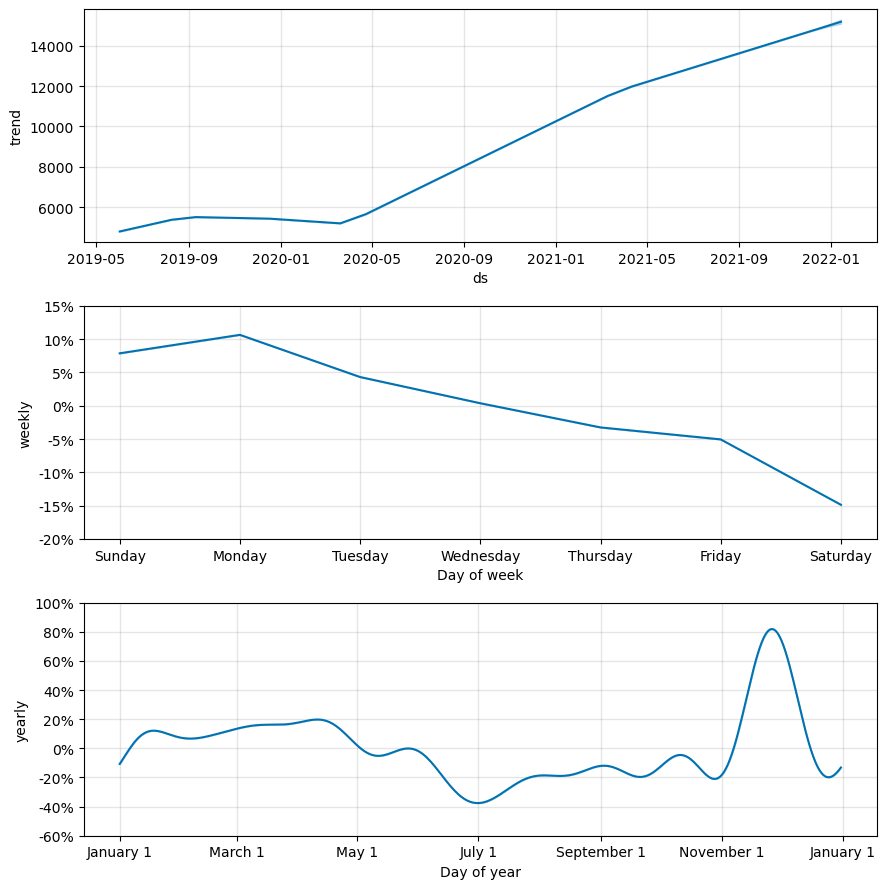

In [238]:
#Graphs of trend and yearly and weekly seasonal components
fig32 = m_ro.plot_components(forecast_ro)

In [239]:
plot_plotly(m_ro, forecast_ro)

##### 1.2.4. Hungary

In [249]:
#Group data to work with specific info of Hungary
df_hu = dataset.groupby(['date','country'], as_index = False).sum().round(2)

In [250]:
df_hu = df_hu.loc[(df_hu['country'] == 'Hungary')] 

##### 1.2.4.1. Forecast

In [251]:
#Build the df model for Hungary
df_hu_model = df_hu[['date','net_sales']].rename(columns={'date': 'ds','net_sales':'y' })
df_hu_model.tail()

ds         y
16068  2022-01-10  12203.83
16088  2022-01-11  13096.11
16108  2022-01-12  10267.21
16128  2022-01-13   9637.03
16148  2022-01-14   2281.91

In [252]:
N_hu =df_hu_model.shape[0]
N_train_hu = N_hu - 60

df_hu_model_train = df_hu_model.iloc[:N_train_hu,:]
df_hu_model_test = df_hu_model.iloc[N_train_hu:,:]

In [253]:
#Creat instance and fit the model
m_hu = Prophet()
m_hu.fit(df_hu_model_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [254]:
#Configure the length of the prediction
future_hu = m_hu.make_future_dataframe(periods=60)
future_hu.tail()

ds
952 2022-01-10
953 2022-01-11
954 2022-01-12
955 2022-01-13
956 2022-01-14

In [255]:
#Forecast the future values
forecast_hu = m_hu.predict(future_hu)
forecast_hu[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat   yhat_lower    yhat_upper
952 2022-01-10  11908.416404  9528.154696  14546.243821
953 2022-01-11  11487.127504  8930.096940  13972.095614
954 2022-01-12  11326.922420  8665.228040  13921.563361
955 2022-01-13  10931.718895  8363.087608  13644.909220
956 2022-01-14  10657.130333  7889.393541  13359.934080

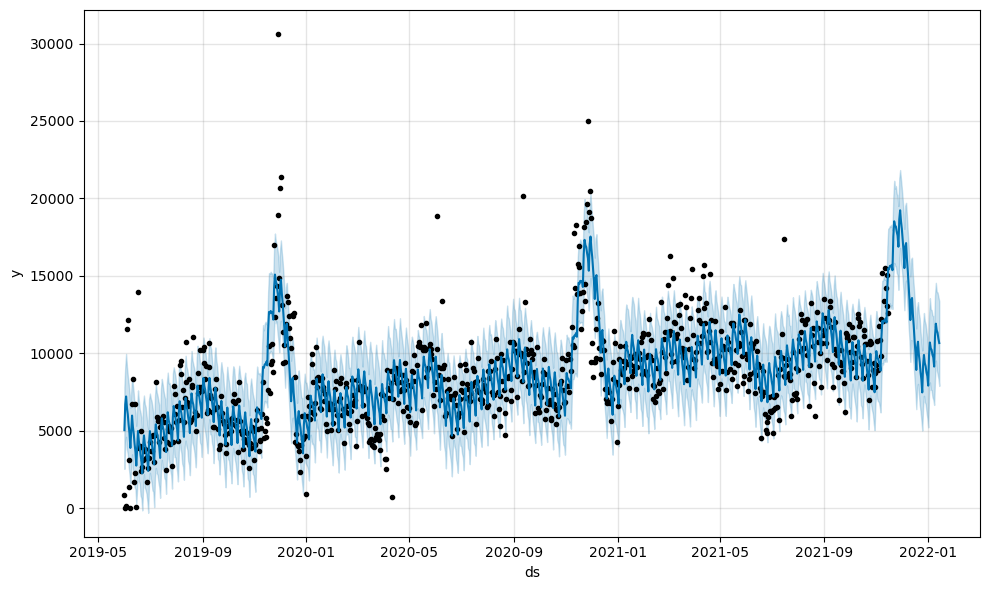

In [256]:
#Graph of historical and forecasted net sales values in Hungary
fig41 = m_hu.plot(forecast_hu)

##### *Metrics Calculation*

In [257]:
print ('The r2 is equals to', metrics.r2_score(list(df_hu_model_test['y']), list(forecast_hu.loc[N_train_hu:,'yhat'])))
print ('The MAE is equals to', metrics.mean_absolute_error(list(df_hu_model_test['y']), list(forecast_hu.loc[N_train_hu:,'yhat'])))

The r2 is equals to 0.5460578493703474
The MAE is equals to 2492.1667937668317


##### *Plot Predicted Vs true values*

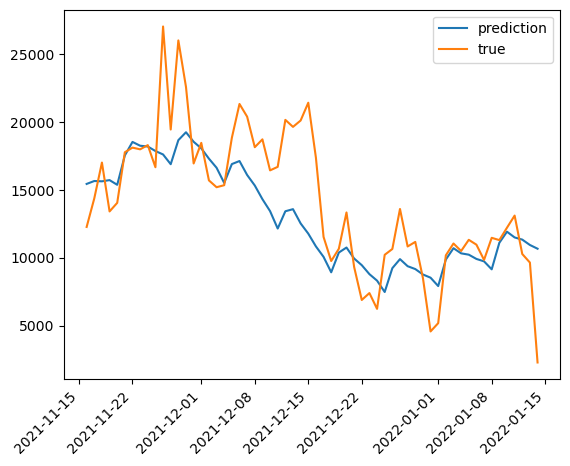

In [258]:
plt.plot(forecast_hu.loc[N_train_hu:,'ds'],forecast_hu.loc[N_train_hu:,'yhat'], label = 'prediction')
plt.plot( pd.to_datetime(df_hu_model_test['ds']),df_hu_model_test['y'], label = 'true')
plt.xticks(rotation=45, ha='right')
plt.legend()

##### *Grid Search*

In [259]:
# Create the grid
changepoint_prior_scale = [0.01, 0.03, 0.05, 0.07] # default 0.05
seasonality_prior_scale = [1, 5, 10, 15] # default 10
seasonality_mode = ['additive', 'multiplicative']
changepoint_range = [0.6, 0.7, 0.8, 0.9] # default 0.8

# Compute the total number of iterations
total_iter = len(changepoint_prior_scale)*len(seasonality_prior_scale)*len(seasonality_mode)*len(changepoint_range)
print(f'Number of iterations : {total_iter}')

# Loop over the parameters, build and assess the models
grid_search_results = []
iteration = 1
for cps in changepoint_prior_scale:
    for sps in seasonality_prior_scale:
        for sm in seasonality_mode:
            for cr in changepoint_range:
                m_hu = Prophet(changepoint_prior_scale = cps, 
                                seasonality_prior_scale = sps, 
                                seasonality_mode = sm, 
                                changepoint_range = cr)
                model_hu = m_hu.fit(df_hu_model_train)
                future_hu = model_hu.make_future_dataframe(periods=60, freq='D')
                forecast_hu = model_hu.predict(future_hu) 

                r2_score = metrics.r2_score(list(df_hu_model_test['y']), list(forecast_hu.loc[N_train_hu:,'yhat']))   
                mae = metrics.mean_absolute_error(list(df_hu_model_test['y']), list(forecast_hu.loc[N_train_hu:,'yhat']))
                mse = metrics.mean_squared_error(list(df_hu_model_test['y']), list(forecast_hu.loc[N_train_hu:,'yhat']))
                
                print(f'iteration : {iteration} / {total_iter} ')
                print(f'r2_score : {r2_score}')
                print(f'mae : {mae}')
                print(f'mse : {mse}')
                
                grid_search_results.append([iteration, cps, sps, sm, cr, r2_score, mae, mse])
                iteration += 1

# Store the results in a dataframe
grid_search_df_hu = pd.DataFrame(grid_search_results, columns = ['iteration', 'cps', 'sps', 'sm', 'cr', 'r2_score', 'mae', 'mse'])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Number of iterations : 128


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 1 / 128 
r2_score : 0.589029113226619
mae : 2427.756021387867
mse : 10872056.02826542


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 2 / 128 
r2_score : 0.5883678457602002
mae : 2427.4836423383326
mse : 10889549.571423717


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 3 / 128 
r2_score : 0.5873115215252205
mae : 2426.967411646433
mse : 10917494.16953596


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 4 / 128 
r2_score : 0.587856119893186
mae : 2427.1796849939487
mse : 10903087.056623632


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 5 / 128 
r2_score : 0.572963355366402
mae : 2629.9396496170507
mse : 11297068.663501406


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 6 / 128 
r2_score : 0.5749200293880672
mae : 2625.0711369989335
mse : 11245305.703454247


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 7 / 128 
r2_score : 0.5735238506622433
mae : 2632.0826532485225
mse : 11282241.004277635


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 8 / 128 
r2_score : 0.5737763838126824
mae : 2630.35877263125
mse : 11275560.349640215


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 9 / 128 
r2_score : 0.5884975993560284
mae : 2427.370880767107
mse : 10886116.996491732


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 10 / 128 
r2_score : 0.5870551163735322
mae : 2427.3096498360455
mse : 10924277.256282024


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 11 / 128 
r2_score : 0.586504161560994
mae : 2426.876485287396
mse : 10938852.526170326


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 12 / 128 
r2_score : 0.5872537126493873
mae : 2427.028329503234
mse : 10919023.478198


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 13 / 128 
r2_score : 0.572740965867411
mae : 2618.556304430065
mse : 11302951.880952915


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 14 / 128 
r2_score : 0.5754548497287229
mae : 2622.191854914059
mse : 11231157.264000747


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 15 / 128 
r2_score : 0.5749185342455643
mae : 2624.410256283324
mse : 11245345.256798744


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 16 / 128 
r2_score : 0.5763827734830249
mae : 2614.940661499141
mse : 11206609.444747815


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 17 / 128 
r2_score : 0.5883524287572349
mae : 2427.5372326655697
mse : 10889957.42153043


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 18 / 128 
r2_score : 0.5887086453555632
mae : 2427.4428802337643
mse : 10880533.866383666


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 19 / 128 
r2_score : 0.5886146135150865
mae : 2427.505401464242
mse : 10883021.43781757


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 20 / 128 
r2_score : 0.5859712564752665
mae : 2426.183709119855
mse : 10952950.298387881


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 21 / 128 
r2_score : 0.5705558126480248
mae : 2638.502215458516
mse : 11360759.158782333


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 22 / 128 
r2_score : 0.5761033846866659
mae : 2618.775823975682
mse : 11214000.553815253


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 23 / 128 
r2_score : 0.5739890310575018
mae : 2628.121430693762
mse : 11269934.859284721


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 24 / 128 
r2_score : 0.5764346520918406
mae : 2613.911409277083
mse : 11205237.018719925


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 25 / 128 
r2_score : 0.5887365529122002
mae : 2427.8119453298923
mse : 10879795.584113233


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 26 / 128 
r2_score : 0.588413600066556
mae : 2427.30508852598
mse : 10888339.1611532


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 27 / 128 
r2_score : 0.5870544987556087
mae : 2426.911160150919
mse : 10924293.595095513


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 28 / 128 
r2_score : 0.5871047728169543
mae : 2427.0180909026208
mse : 10922963.616672933


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 29 / 128 
r2_score : 0.5712858782105654
mae : 2631.5412405212287
mse : 11341445.591919808


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 30 / 128 
r2_score : 0.5750671020361136
mae : 2627.3018935710593
mse : 11241414.960530002


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 31 / 128 
r2_score : 0.5740728819565749
mae : 2628.1817651496162
mse : 11267716.620226715


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 32 / 128 
r2_score : 0.5761984325656793
mae : 2614.957241616781
mse : 11211486.103523862


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 33 / 128 
r2_score : 0.573729020450902
mae : 2422.1361747298915
mse : 11276813.326772014


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 34 / 128 
r2_score : 0.5635061201773124
mae : 2433.1032933866927
mse : 11547255.706324618


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 35 / 128 
r2_score : 0.5605331961709559
mae : 2440.84839374711
mse : 11625903.117625814


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 36 / 128 
r2_score : 0.5618010391359437
mae : 2437.487297035077
mse : 11592362.88352648


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 37 / 128 
r2_score : 0.5757574573060193
mae : 2611.8357760261133
mse : 11223151.912184281


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 38 / 128 
r2_score : 0.5755750608910941
mae : 2609.7572269753405
mse : 11227977.129994702


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 39 / 128 
r2_score : 0.574300387087139
mae : 2612.691878620228
mse : 11261698.070967346


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 40 / 128 
r2_score : 0.5774713520219001
mae : 2597.0538414702564
mse : 11177811.573057344


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 41 / 128 
r2_score : 0.5730130580865792
mae : 2422.190210905604
mse : 11295753.799660888


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 42 / 128 
r2_score : 0.5617035192873715
mae : 2437.6259550834075
mse : 11594942.72869719


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 43 / 128 
r2_score : 0.5646719964178364
mae : 2430.506899527745
mse : 11516412.957563218


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 44 / 128 
r2_score : 0.5647048445431561
mae : 2430.079912776923
mse : 11515543.97469754


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 45 / 128 
r2_score : 0.5769035392321074
mae : 2610.6623621651106
mse : 11192832.81340033


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 46 / 128 
r2_score : 0.5762978615816936
mae : 2604.987063880027
mse : 11208855.752159


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 47 / 128 
r2_score : 0.5763797133195875
mae : 2602.645239383575
mse : 11206690.400040315


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 48 / 128 
r2_score : 0.5768890857046033
mae : 2599.7852481313553
mse : 11193215.17518285


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 49 / 128 
r2_score : 0.5733284385623223
mae : 2422.181883383983
mse : 11287410.546372509


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 50 / 128 
r2_score : 0.5623368016443369
mae : 2436.042219753896
mse : 11578189.51943535


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 51 / 128 
r2_score : 0.5616564275732856
mae : 2438.165767433817
mse : 11596188.519507406


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 52 / 128 
r2_score : 0.562095814842942
mae : 2437.0199551158335
mse : 11584564.720431717


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 53 / 128 
r2_score : 0.576899601664121
mae : 2611.0536133271285
mse : 11192936.980048481


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 54 / 128 
r2_score : 0.5753250578094207
mae : 2611.923871314945
mse : 11234590.852763562


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 55 / 128 
r2_score : 0.5749629901403444
mae : 2610.1417448043267
mse : 11244169.195441624


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 56 / 128 
r2_score : 0.5765949287780792
mae : 2602.176535205823
mse : 11200996.968709348


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 57 / 128 
r2_score : 0.5712945011968316
mae : 2422.6299233970376
mse : 11341217.474569324


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 58 / 128 
r2_score : 0.5634625237826135
mae : 2433.3982433256037
mse : 11548409.029980991


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 59 / 128 
r2_score : 0.5600144087977285
mae : 2441.886629987835
mse : 11639627.411900692


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 60 / 128 
r2_score : 0.5627489695295316
mae : 2435.2586524667045
mse : 11567285.797334565


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 61 / 128 
r2_score : 0.576272448771737
mae : 2611.5725833075994
mse : 11209528.036991272


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 62 / 128 
r2_score : 0.575956935542191
mae : 2608.8952716554636
mse : 11217874.80222376


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 63 / 128 
r2_score : 0.5758139056664847
mae : 2607.4857171740164
mse : 11221658.595364444


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 64 / 128 
r2_score : 0.5764806482247326
mae : 2603.766453589674
mse : 11204020.211033592


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 65 / 128 
r2_score : 0.5656034670602678
mae : 2426.422901982448
mse : 11491771.3069278


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 66 / 128 
r2_score : 0.5489729100046383
mae : 2480.610625081392
mse : 11931725.45917842


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 67 / 128 
r2_score : 0.5477958253224064
mae : 2485.46072021091
mse : 11962864.72238928


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 68 / 128 
r2_score : 0.5470684928416341
mae : 2488.0136531079424
mse : 11982105.986762578


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 69 / 128 
r2_score : 0.5766626736831167
mae : 2601.5119329759113
mse : 11199204.806717094


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 70 / 128 
r2_score : 0.5763081013674958
mae : 2593.2049957401896
mse : 11208584.863080135


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 71 / 128 
r2_score : 0.5744962789833138
mae : 2601.483116701583
mse : 11256515.836071305


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 72 / 128 
r2_score : 0.5760538096335344
mae : 2594.7102029730654
mse : 11215312.04027962


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 73 / 128 
r2_score : 0.5667795475105817
mae : 2425.0456805507024
mse : 11460658.610235462


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 74 / 128 
r2_score : 0.547629927743662
mae : 2485.6638099932097
mse : 11967253.470665889


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 75 / 128 
r2_score : 0.5456077272275726
mae : 2493.6574040730643
mse : 12020749.905617584


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 76 / 128 
r2_score : 0.5470927247734982
mae : 2487.8913153536882
mse : 11981464.94154653


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 77 / 128 
r2_score : 0.5761190720616862
mae : 2601.761320978459
mse : 11213585.551133446


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 78 / 128 
r2_score : 0.5763562461396562
mae : 2593.3916117304193
mse : 11207311.21407666


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 79 / 128 
r2_score : 0.5727130811352534
mae : 2608.2610457351193
mse : 11303689.559411675


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 80 / 128 
r2_score : 0.5740736523081943
mae : 2602.0961534922985
mse : 11267696.240909744


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 81 / 128 
r2_score : 0.5650218197729124
mae : 2427.300919406318
mse : 11507158.532885494


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 82 / 128 
r2_score : 0.5485607650464362
mae : 2482.1908648964654
mse : 11942628.574755583


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 83 / 128 
r2_score : 0.5460578493703474
mae : 2492.1667937668317
mse : 12008842.12014345


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 84 / 128 
r2_score : 0.5462170546239761
mae : 2491.04017173466
mse : 12004630.414416471


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 85 / 128 
r2_score : 0.577033871660551
mae : 2598.204483342018
mse : 11189384.925703311


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 86 / 128 
r2_score : 0.5762051355790767
mae : 2593.892249173661
mse : 11211308.778220389


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 87 / 128 
r2_score : 0.5749910764758912
mae : 2598.7927735490225
mse : 11243426.183652902


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 88 / 128 
r2_score : 0.5742244785523989
mae : 2601.10598657024
mse : 11263706.198232027


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 89 / 128 
r2_score : 0.5659822423977484
mae : 2425.9010591771485
mse : 11481750.970150305


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 90 / 128 
r2_score : 0.5494828313337696
mae : 2478.7087863955444
mse : 11918235.71224318


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 91 / 128 
r2_score : 0.5450252460357812
mae : 2495.9209796735545
mse : 12036159.192154368


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 92 / 128 
r2_score : 0.5467578273132199
mae : 2489.175751212298
mse : 11990324.508170474


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 93 / 128 
r2_score : 0.576834559753048
mae : 2599.4386545882558
mse : 11194657.635511262


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 94 / 128 
r2_score : 0.575092104656036
mae : 2598.066830019541
mse : 11240753.527096637


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 95 / 128 
r2_score : 0.5747709789384461
mae : 2599.2599976734327
mse : 11249248.768258769


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 96 / 128 
r2_score : 0.5746648245076997
mae : 2598.6231099509014
mse : 11252057.037544666


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 97 / 128 
r2_score : 0.5662800766722207
mae : 2425.670339849739
mse : 11473871.893983565


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 98 / 128 
r2_score : 0.5472739361795542
mae : 2485.313428666476
mse : 11976671.072630247


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 99 / 128 
r2_score : 0.5366621778209336
mae : 2524.244199412399
mse : 12257400.52366057


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 100 / 128 
r2_score : 0.5536893721467337
mae : 2457.6696917108743
mse : 11806953.504973473


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 101 / 128 
r2_score : 0.5773895749901834
mae : 2595.0230894206625
mse : 11179974.948856613


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 102 / 128 
r2_score : 0.5738888895376736
mae : 2602.6533186330416
mse : 11272584.059628021


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 103 / 128 
r2_score : 0.5706772548524163
mae : 2615.3609054621597
mse : 11357546.458095172


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 104 / 128 
r2_score : 0.5725706986170069
mae : 2608.349697207526
mse : 11307456.226992376


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 105 / 128 
r2_score : 0.5660438345761774
mae : 2425.928739142712
mse : 11480121.57586391


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 106 / 128 
r2_score : 0.5489013425374691
mae : 2479.204095641541
mse : 11933618.745388964


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 107 / 128 
r2_score : 0.5351182475839708
mae : 2529.2275171008764
mse : 12298244.526436001


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 108 / 128 
r2_score : 0.5602861436183091
mae : 2437.565358416275
mse : 11632438.78543282


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 109 / 128 
r2_score : 0.5773188672321804
mae : 2594.613202053575
mse : 11181845.49183516


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 110 / 128 
r2_score : 0.5728124574134208
mae : 2607.200833865544
mse : 11301060.603203611


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 111 / 128 
r2_score : 0.5710267570609971
mae : 2614.1979847789867
mse : 11348300.52920827


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 112 / 128 
r2_score : 0.5707997463119008
mae : 2614.5145712925796
mse : 11354305.999820974


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 113 / 128 
r2_score : 0.565673674810373
mae : 2426.3050907119205
mse : 11489913.991440672


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 114 / 128 
r2_score : 0.5481268713414627
mae : 2482.2014555497717
mse : 11954107.043967407


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 115 / 128 
r2_score : 0.5381389934217808
mae : 2518.999345628719
mse : 12218332.009387244


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 116 / 128 
r2_score : 0.5559533471131306
mae : 2449.351322198235
mse : 11747061.032116074


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 117 / 128 
r2_score : 0.5774651709192586
mae : 2594.083494758001
mse : 11177975.091438811


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 118 / 128 
r2_score : 0.572688929576968
mae : 2608.7697334943705
mse : 11304328.47837966


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 119 / 128 
r2_score : 0.5709152189708341
mae : 2614.2776028996063
mse : 11351251.220862025


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 120 / 128 
r2_score : 0.5703706137107268
mae : 2615.68873308515
mse : 11365658.516102964


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 121 / 128 
r2_score : 0.5666906384116072
mae : 2425.518072993941
mse : 11463010.661771433


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 122 / 128 
r2_score : 0.5485205066067116
mae : 2480.589041234203
mse : 11943693.594265196


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 123 / 128 
r2_score : 0.5354425755605163
mae : 2528.096318404277
mse : 12289664.570906254


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 124 / 128 
r2_score : 0.5603618846600424
mae : 2437.706701271907
mse : 11630435.089122776


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 125 / 128 
r2_score : 0.5776509682254308
mae : 2593.852799494921
mse : 11173059.904529918


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 126 / 128 
r2_score : 0.572727158413942
mae : 2607.146333672613
mse : 11303317.151127895


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 127 / 128 
r2_score : 0.570564332885179
mae : 2615.187712110817
mse : 11360533.759614907
iteration : 128 / 128 
r2_score : 0.5703113838821596
mae : 2615.5874121128245
mse : 11367225.415451437


##### 1.2.4.2. Analysis of trend and yearly and weekly seasonal components

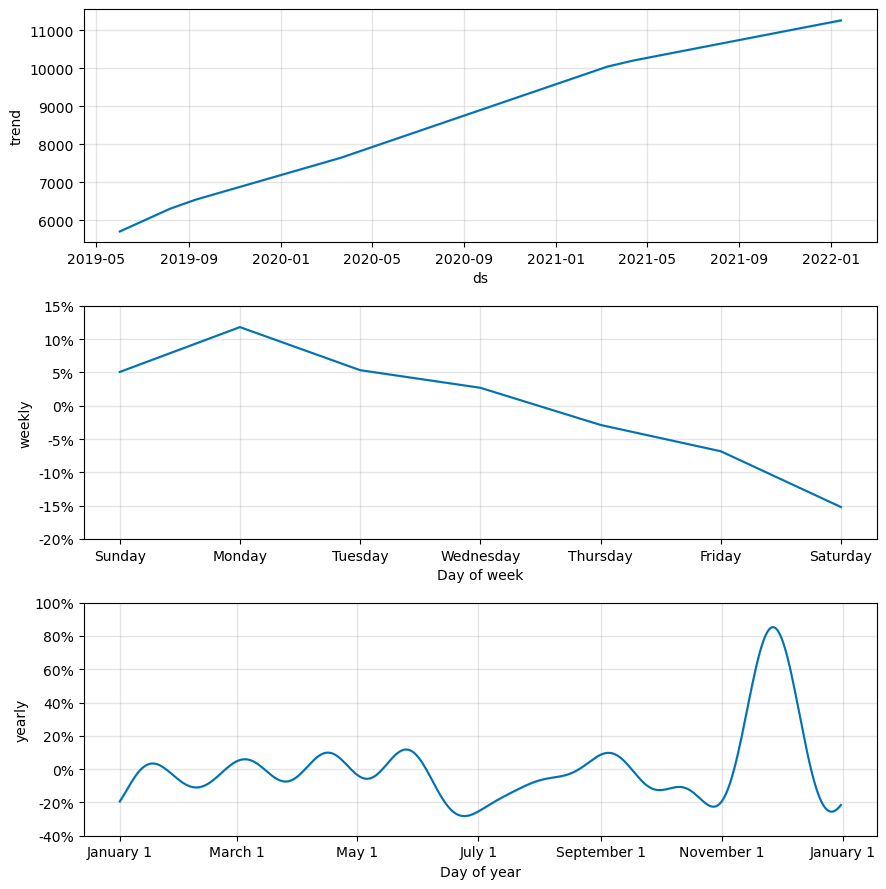

In [260]:
#Graphs of trend and yearly and weekly seasonal components
fig42 = m_hu.plot_components(forecast_hu)

In [261]:
plot_plotly(m_hu, forecast_hu)

##### 1.2.5. Spain

In [362]:
#Group data to work with specific info of Spain
df_es = dataset.groupby(['date','country'], as_index = False).sum().round(2)

In [363]:
df_es = df_es.loc[(df_es['country'] == 'Spain')] 

##### 1.2.5.1. Forecast

In [364]:
#Build the df model for Spain
df_es_model = df_es[['date','net_sales']].rename(columns={'date': 'ds','net_sales':'y' })
df_es_model.tail()

ds        y
16078  2022-01-10  8649.35
16098  2022-01-11  8908.65
16118  2022-01-12  7147.32
16139  2022-01-13  5833.34
16159  2022-01-14   542.60

In [365]:
N_es =df_es_model.shape[0]
N_train_es = N_es - 60

df_es_model_train = df_es_model.iloc[:N_train_es,:]
df_es_model_test = df_es_model.iloc[N_train_es:,:]

In [366]:
#Creat instance and fit the model
m_es = Prophet()
m_es.fit(df_es_model_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [367]:
#Configure the length of the prediction
future_es = m_es.make_future_dataframe(periods=60)
future_es.tail()

ds
950 2022-01-10
951 2022-01-11
952 2022-01-12
953 2022-01-13
954 2022-01-14

In [368]:
#Forecast the future values
forecast_es = m_es.predict(future_es)
forecast_es[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat   yhat_lower    yhat_upper
950 2022-01-10  10323.674438  9004.034964  11585.566294
951 2022-01-11  10272.927705  8905.269353  11690.612983
952 2022-01-12  10155.043317  8892.190482  11602.032824
953 2022-01-13  10160.377657  8788.906783  11568.170141
954 2022-01-14  10000.497225  8643.757020  11417.120064

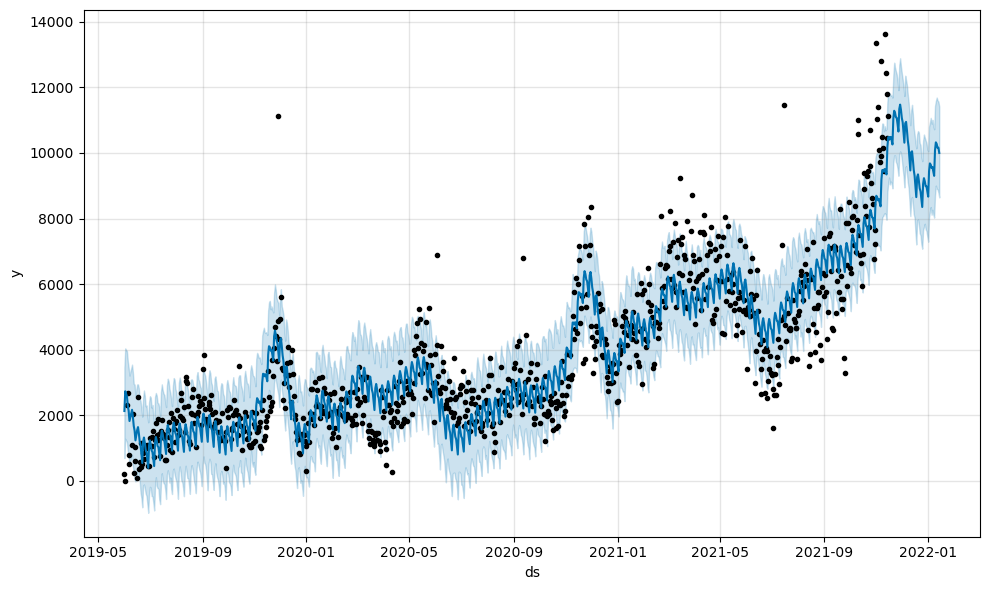

In [369]:
#Graph of historical and forecasted net sales values in Spain
fig51 = m_es.plot(forecast_es)

##### *Metrics Calculation*

In [370]:
print ('The r2 is equals to', metrics.r2_score(list(df_es_model_test['y']), list(forecast_es.loc[N_train_es:,'yhat'])))
print ('The MAE is equals to', metrics.mean_absolute_error(list(df_es_model_test['y']), list(forecast_es.loc[N_train_es:,'yhat'])))

The r2 is equals to 0.10409565081957561
The MAE is equals to 3091.55023217323


##### *Plot predicted Vs true values*

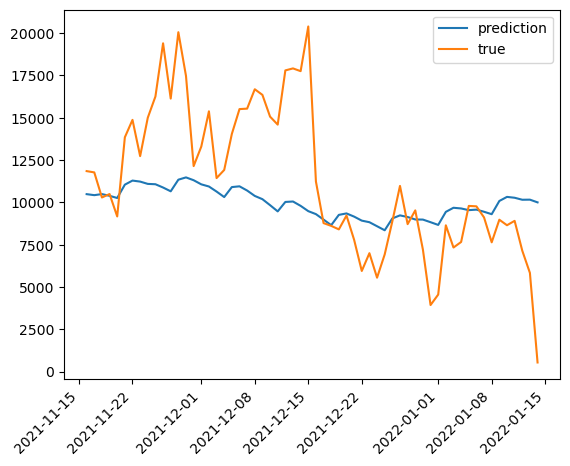

In [371]:
plt.plot(forecast_es.loc[N_train_es:,'ds'],forecast_es.loc[N_train_es:,'yhat'], label = 'prediction')
plt.plot( pd.to_datetime(df_es_model_test['ds']),df_es_model_test['y'], label = 'true')
plt.xticks(rotation=45, ha='right')
plt.legend()

##### *Grid Search*

In [372]:
# Create the grid
changepoint_prior_scale = [0.01, 0.03, 0.05, 0.07] # default 0.05
seasonality_prior_scale = [1, 5, 10, 15] # default 10
seasonality_mode = ['additive', 'multiplicative']
changepoint_range = [0.6, 0.7, 0.8, 0.9] # default 0.8

# Compute the total number of iterations
total_iter = len(changepoint_prior_scale)*len(seasonality_prior_scale)*len(seasonality_mode)*len(changepoint_range)
print(f'Number of iterations : {total_iter}')

# Loop over the parameters, build and assess the models
grid_search_results = []
iteration = 1
for cps in changepoint_prior_scale:
    for sps in seasonality_prior_scale:
        for sm in seasonality_mode:
            for cr in changepoint_range:
                m_es = Prophet(changepoint_prior_scale = cps, 
                                seasonality_prior_scale = sps, 
                                seasonality_mode = sm, 
                                changepoint_range = cr)
                model_es = m_es.fit(df_es_model_train)
                future_es = model_es.make_future_dataframe(periods=60, freq='D')
                forecast_es = model_es.predict(future_es) 

                r2_score = metrics.r2_score(list(df_es_model_test['y']), list(forecast_es.loc[N_train_es:,'yhat']))   
                mae = metrics.mean_absolute_error(list(df_es_model_test['y']), list(forecast_es.loc[N_train_es:,'yhat']))
                mse = metrics.mean_squared_error(list(df_es_model_test['y']), list(forecast_es.loc[N_train_es:,'yhat']))
                
                print(f'iteration : {iteration} / {total_iter} ')
                print(f'r2_score : {r2_score}')
                print(f'mae : {mae}')
                print(f'mse : {mse}')
                
                grid_search_results.append([iteration, cps, sps, sm, cr, r2_score, mae, mse])
                iteration += 1

# Store the results in a dataframe
grid_search_df_es = pd.DataFrame(grid_search_results, columns = ['iteration', 'cps', 'sps', 'sm', 'cr', 'r2_score', 'mae', 'mse'])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Number of iterations : 128


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 1 / 128 
r2_score : -0.13968635985634115
mae : 3447.0553758894343
mse : 21548071.88773671


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 2 / 128 
r2_score : -0.1538877179617677
mae : 3476.8480723668167
mse : 21816577.238101523


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 3 / 128 
r2_score : -0.16805911584311617
mae : 3505.827729250305
mse : 22084516.129934452


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 4 / 128 
r2_score : -0.15817117648354095
mae : 3485.8185784461953
mse : 21897564.67061492


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 5 / 128 
r2_score : 0.3575317030669517
mae : 2486.153414440477
mse : 12147160.42547894


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 6 / 128 
r2_score : 0.3696219356674062
mae : 2461.4075768227426
mse : 11918570.165570162


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 7 / 128 
r2_score : 0.3575656987816175
mae : 2497.333675332709
mse : 12146517.66784904


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 8 / 128 
r2_score : 0.3508191881959025
mae : 2507.21436107856
mse : 12274074.073025888


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 9 / 128 
r2_score : -0.14080216291699466
mae : 3449.1743207240597
mse : 21569168.397627857


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 10 / 128 
r2_score : -0.14203342885087533
mae : 3452.204793928261
mse : 21592447.96628


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 11 / 128 
r2_score : -0.14992685731269484
mae : 3468.7836200077822
mse : 21741689.169761132


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 12 / 128 
r2_score : -0.14921419283117565
mae : 3466.998446385213
mse : 21728214.80872592


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 13 / 128 
r2_score : 0.3676089565543793
mae : 2466.8803710956136
mse : 11956629.60030928


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 14 / 128 
r2_score : 0.37643752012197174
mae : 2452.8112577910265
mse : 11789707.779428741


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 15 / 128 
r2_score : 0.36500066308010404
mae : 2483.0667272667874
mse : 12005944.655106535


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 16 / 128 
r2_score : 0.3464955427060519
mae : 2515.1448966144353
mse : 12355821.321316315


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 17 / 128 
r2_score : -0.13614144765157188
mae : 3439.3119982320873
mse : 21481048.164618965


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 18 / 128 
r2_score : -0.15417924336922506
mae : 3477.2717359040853
mse : 21822089.114577595


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 19 / 128 
r2_score : -0.15670225328490028
mae : 3482.4135399168767
mse : 21869791.711494956


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 20 / 128 
r2_score : -0.1420493577556332
mae : 3451.9756815966466
mse : 21592749.13438809


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 21 / 128 
r2_score : 0.37244507121757886
mae : 2458.3328295026254
mse : 11865193.087518958


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 22 / 128 
r2_score : 0.3751998830254587
mae : 2455.522154888044
mse : 11813107.807775097


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 23 / 128 
r2_score : 0.37029520719073217
mae : 2468.979597933158
mse : 11905840.607951852


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 24 / 128 
r2_score : 0.3533452521097564
mae : 2498.604973761083
mse : 12226313.734106325


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 25 / 128 
r2_score : -0.13372759660103029
mae : 3434.5210684627277
mse : 21435409.436460532


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 26 / 128 
r2_score : -0.1451788552376243
mae : 3458.753278192765
mse : 21651918.603366323


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 27 / 128 
r2_score : -0.15591805185559782
mae : 3480.8713713876787
mse : 21854964.800014496


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 28 / 128 
r2_score : -0.14975447298036015
mae : 3468.2308277367692
mse : 21738429.89587991


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 29 / 128 
r2_score : 0.3654918059852059
mae : 2474.2238715641747
mse : 11996658.606769849


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 30 / 128 
r2_score : 0.3651076069899203
mae : 2476.099206293349
mse : 12003922.664550321


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 31 / 128 
r2_score : 0.3687178787829507
mae : 2472.1965348459034
mse : 11935663.186442418


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 32 / 128 
r2_score : 0.3415988695503135
mae : 2523.072987103226
mse : 12448402.81468779


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 33 / 128 
r2_score : -0.07102142252595622
mae : 3327.1591678142595
mse : 20249822.59926705


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 34 / 128 
r2_score : -0.061082957589730924
mae : 3310.6936896996795
mse : 20061915.851899706


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 35 / 128 
r2_score : 0.026280914232549524
mae : 3177.413203975259
mse : 18410125.44997298


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 36 / 128 
r2_score : 0.12726491602494883
mae : 3128.745614524143
mse : 16500818.98919526


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 37 / 128 
r2_score : 0.4442630033696029
mae : 2356.7406742653134
mse : 10507330.065419193


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 38 / 128 
r2_score : 0.4378203746325309
mae : 2365.2731255981657
mse : 10629140.97064923


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 39 / 128 
r2_score : 0.44801665351399866
mae : 2352.3842447717852
mse : 10436359.730069168


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 40 / 128 
r2_score : 0.4435135197275998
mae : 2357.6954195288245
mse : 10521500.567028603


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 41 / 128 
r2_score : -0.06776203534757741
mae : 3321.463739566044
mse : 20188197.30330534


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 42 / 128 
r2_score : -0.06406649042165902
mae : 3315.729446932039
mse : 20118325.56443668


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 43 / 128 
r2_score : 0.023087023946986585
mae : 3182.151917554705
mse : 18470512.394924685


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 44 / 128 
r2_score : 0.12934978852333723
mae : 3136.418428995675
mse : 16461400.26483876


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 45 / 128 
r2_score : 0.44074218060596704
mae : 2363.154268022872
mse : 10573898.329010913


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 46 / 128 
r2_score : 0.4506448773712046
mae : 2347.4286545172704
mse : 10386667.851139182


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 47 / 128 
r2_score : 0.44664924758957647
mae : 2354.9522481364565
mse : 10462213.300136358


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 48 / 128 
r2_score : 0.4407765425759814
mae : 2361.1240142430124
mse : 10573248.646584101


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 49 / 128 
r2_score : -0.062390801634206294
mae : 3312.335692019171
mse : 20086643.284359157


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 50 / 128 
r2_score : -0.06105575061144286
mae : 3310.591500497149
mse : 20061401.449038845


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 51 / 128 
r2_score : 0.021075897837653845
mae : 3184.970609457735
mse : 18508536.79488738


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 52 / 128 
r2_score : 0.12822537285770774
mae : 3130.163493019158
mse : 16482659.613417555


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 53 / 128 
r2_score : 0.44068128983655064
mae : 2362.182049343552
mse : 10575049.591957368


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 54 / 128 
r2_score : 0.44667567496904637
mae : 2353.7185016778008
mse : 10461713.637165315


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 55 / 128 
r2_score : 0.4441265754624565
mae : 2358.0243902233988
mse : 10509909.51047902


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 56 / 128 
r2_score : 0.44320138797570985
mae : 2357.8069659898383
mse : 10527402.048054503


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 57 / 128 
r2_score : -0.06839821685548753
mae : 3322.5091306658887
mse : 20200225.599290054


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 58 / 128 
r2_score : -0.0610292746669705
mae : 3310.6527051118733
mse : 20060900.867848363


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 59 / 128 
r2_score : 0.03317393023872173
mae : 3167.357487266862
mse : 18279799.063998647


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 60 / 128 
r2_score : 0.12666197476679641
mae : 3128.0803541984214
mse : 16512218.811139595


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 61 / 128 
r2_score : 0.437390461521429
mae : 2367.4433638164523
mse : 10637269.346095147


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 62 / 128 
r2_score : 0.4445916774028025
mae : 2356.803628848565
mse : 10501115.81916296


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 63 / 128 
r2_score : 0.44419932339098556
mae : 2358.6799822126177
mse : 10508534.063997563


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 64 / 128 
r2_score : 0.4427714252508853
mae : 2358.801589347716
mse : 10535531.361548027


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 65 / 128 
r2_score : -0.033622194062180366
mae : 3263.694843871308
mse : 19542714.66863874


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 66 / 128 
r2_score : -0.02667836617299857
mae : 3252.608346571125
mse : 19411427.58141676


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 67 / 128 
r2_score : 0.09623612281562433
mae : 3093.896284257548
mse : 17087480.978155557


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 68 / 128 
r2_score : 0.13767934379348623
mae : 3276.6275901246922
mse : 16303913.203418924


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 69 / 128 
r2_score : 0.45067608329640607
mae : 2350.637222849558
mse : 10386077.840112245


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 70 / 128 
r2_score : 0.46293916191776574
mae : 2330.5371930177944
mse : 10154219.577167574


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 71 / 128 
r2_score : 0.46273456283982983
mae : 2336.1388780120587
mse : 10158087.935862403


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 72 / 128 
r2_score : 0.46240754061472633
mae : 2335.241172553245
mse : 10164270.95135125


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 73 / 128 
r2_score : -0.03693750278240615
mae : 3269.5193255223476
mse : 19605397.274265844


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 74 / 128 
r2_score : -0.021957086017125427
mae : 3245.7387666301574
mse : 19322162.246861275


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 75 / 128 
r2_score : 0.09929652988873172
mae : 3092.1205816308507
mse : 17029617.802864622


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 76 / 128 
r2_score : 0.13045849775197127
mae : 3310.3681840798913
mse : 16440437.878165806


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 77 / 128 
r2_score : 0.45165798785372324
mae : 2349.126731647174
mse : 10367512.951794522


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 78 / 128 
r2_score : 0.45955528317463445
mae : 2336.355868552929
mse : 10218198.637534294


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 79 / 128 
r2_score : 0.46063766067158296
mae : 2336.4195516903587
mse : 10197734.105417885


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 80 / 128 
r2_score : 0.46457723901668757
mae : 2330.9498492895787
mse : 10123248.422007244


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 81 / 128 
r2_score : -0.0388522786992862
mae : 3272.8698692746852
mse : 19641599.979289915


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 82 / 128 
r2_score : -0.0270712013156873
mae : 3253.4005418615616
mse : 19418854.923001993


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 83 / 128 
r2_score : 0.10409565081957561
mae : 3091.55023217323
mse : 16938880.731282223


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 84 / 128 
r2_score : 0.14216541250218262
mae : 3246.785101214932
mse : 16219095.01621126


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 85 / 128 
r2_score : 0.4468349499148595
mae : 2357.2660811272676
mse : 10458702.222706756


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 86 / 128 
r2_score : 0.4607085511507488
mae : 2333.4656936100787
mse : 10196393.777767202


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 87 / 128 
r2_score : 0.4613574223811351
mae : 2334.9636349760467
mse : 10184125.556955988


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 88 / 128 
r2_score : 0.46469940466773485
mae : 2331.8982269712938
mse : 10120938.633697318


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 89 / 128 
r2_score : -0.030148123398886506
mae : 3257.473133133574
mse : 19477030.347905822


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 90 / 128 
r2_score : -0.02829722826911696
mae : 3255.3997872850696
mse : 19442035.438150156


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 91 / 128 
r2_score : 0.10785256918774222
mae : 3091.5751610344523
mse : 16867848.603562612


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 92 / 128 
r2_score : 0.14054211318060883
mae : 3257.384049825473
mse : 16249786.767651537


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 93 / 128 
r2_score : 0.4556340463459496
mae : 2341.220896500844
mse : 10292337.53754183


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 94 / 128 
r2_score : 0.4566126374415137
mae : 2340.8989646584214
mse : 10273835.29690909


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 95 / 128 
r2_score : 0.4593824545634858
mae : 2338.6485753905736
mse : 10221466.311403584


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 96 / 128 
r2_score : 0.46503787544297426
mae : 2332.423461740472
mse : 10114539.16025124


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 97 / 128 
r2_score : 0.048042279253218356
mae : 3134.315554891292
mse : 17998682.903709847


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 98 / 128 
r2_score : 0.08163219752734385
mae : 3087.559953311618
mse : 17363597.673975863


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 99 / 128 
r2_score : 0.1281613378422688
mae : 3114.881570057693
mse : 16483870.324683929


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 100 / 128 
r2_score : 0.07716881950988197
mae : 3467.785750591995
mse : 17447986.847848695


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 101 / 128 
r2_score : 0.4712190967599378
mae : 2332.212557506496
mse : 9997670.690132206


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 102 / 128 
r2_score : 0.4773899567318787
mae : 2323.4678715653595
mse : 9880998.122162456


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 103 / 128 
r2_score : 0.4709671675509448
mae : 2341.332587632391
mse : 10002433.92052367


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 104 / 128 
r2_score : 0.46822993766201926
mae : 2349.19176419624
mse : 10054186.77858829


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 105 / 128 
r2_score : 0.04860252352821359
mae : 3133.2062902603893
mse : 17988090.35444585


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 106 / 128 
r2_score : 0.07695023347947572
mae : 3094.3834018980397
mse : 17452119.658122428


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 107 / 128 
r2_score : 0.13026769131540528
mae : 3119.630216002077
mse : 16444045.459125433


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 108 / 128 
r2_score : 0.06856495347609826
mae : 3489.916236888875
mse : 17610660.30814333


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 109 / 128 
r2_score : 0.46749623728439615
mae : 2332.963716790332
mse : 10068058.865715027


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 110 / 128 
r2_score : 0.4758167468489678
mae : 2325.283436786097
mse : 9910742.831624217


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 111 / 128 
r2_score : 0.47217166899683194
mae : 2338.564958664338
mse : 9979660.3885599


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 112 / 128 
r2_score : 0.4713168062761889
mae : 2345.796729152354
mse : 9995823.29443243


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 113 / 128 
r2_score : 0.04767146677966172
mae : 3134.6218104235127
mse : 18005693.86226697


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 114 / 128 
r2_score : 0.07944259592416625
mae : 3091.382659596353
mse : 17404996.513527405


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 115 / 128 
r2_score : 0.12798790315321995
mae : 3116.855791456627
mse : 16487149.457679715


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 116 / 128 
r2_score : 0.05531429162689727
mae : 3523.364435358634
mse : 17861190.826138355


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 117 / 128 
r2_score : 0.4714346895020475
mae : 2331.519606150215
mse : 9993594.474017767


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 118 / 128 
r2_score : 0.4743250143034725
mae : 2325.1985805305217
mse : 9938947.047503104


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 119 / 128 
r2_score : 0.4712222347052477
mae : 2340.8245827367473
mse : 9997611.360939983


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 120 / 128 
r2_score : 0.46917772444852035
mae : 2346.689675014933
mse : 10036266.955618445


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 121 / 128 
r2_score : 0.06567993062778488
mae : 3106.0287961312274
mse : 17665207.490528714


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 122 / 128 
r2_score : 0.0752045924187571
mae : 3096.5630458693613
mse : 17485124.527173676


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 123 / 128 
r2_score : 0.12580586320552578
mae : 3114.6627252002363
mse : 16528405.328865848


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 124 / 128 
r2_score : 0.10626920713976518
mae : 3389.9368654155987
mse : 16897785.260204203


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 125 / 128 
r2_score : 0.4690541029302038
mae : 2333.271904776809
mse : 10038604.270038784


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 126 / 128 
r2_score : 0.47519807448385554
mae : 2325.833980360793
mse : 9922440.081909882


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 127 / 128 
r2_score : 0.4714543071746422
mae : 2339.7888794488294
mse : 9993223.562305361
iteration : 128 / 128 
r2_score : 0.4712636450959561
mae : 2342.7370150413526
mse : 9996828.413887782


##### 1.2.5.2. Analysis of trend and yearly and weekly seasonal components

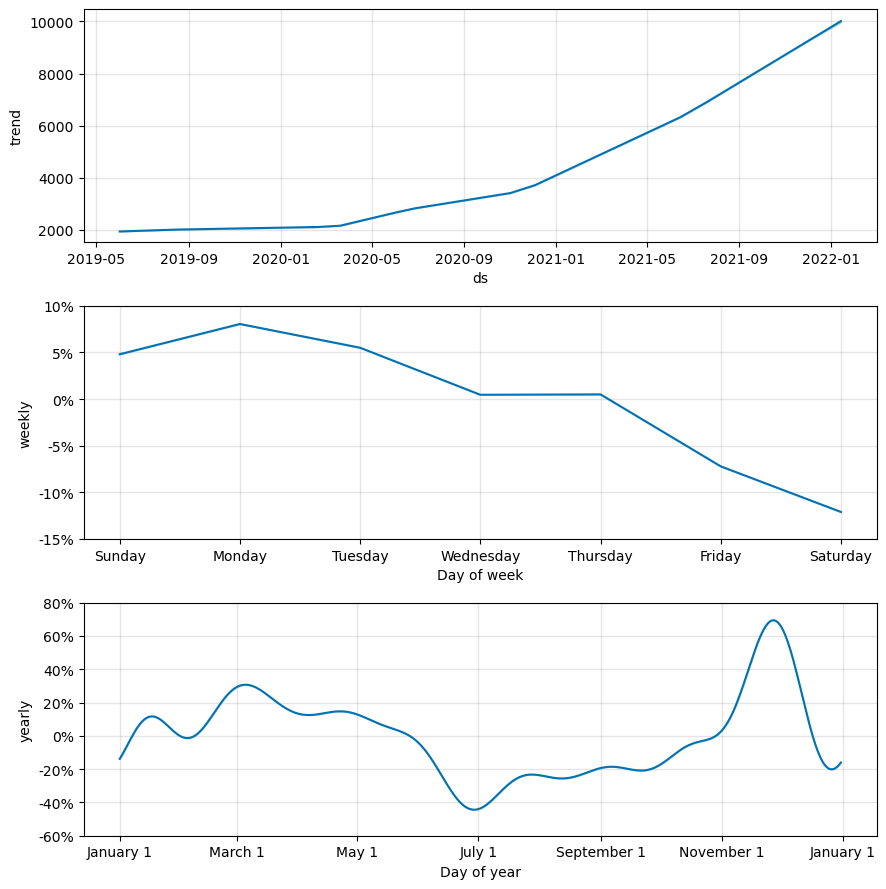

In [373]:
#Graphs of trend and yearly and weekly seasonal components
fig52 = m_es.plot_components(forecast_es)

In [374]:
plot_plotly(m_es, forecast_es)

##### 1.2.6. Germany

In [375]:
#Group data to work with specific info of Germany
df_de = dataset.groupby(['date','country'], as_index = False).sum().round(2)

In [376]:
df_de = df_de.loc[(df_de['country'] == 'Germany')] 

##### 1.2.6.1. Forecast

In [377]:
#Build the df model for Germany
df_de_model = df_de[['date','net_sales']].rename(columns={'date': 'ds','net_sales':'y' })
df_de_model.tail()

ds        y
16067  2022-01-10  5397.87
16087  2022-01-11  5102.69
16107  2022-01-12  4251.69
16127  2022-01-13  6347.86
16147  2022-01-14   843.66

In [378]:
print( 'df_de_model starts on', df_de_model['ds'].min(), 'and ends on', df_de_model['ds'].max())
print(df_de_model.shape)

df_de_model starts on 2019-06-01 and ends on 2022-01-14
(954, 2)


In [379]:
N_de = df_de_model.shape[0]
N_train_de = N_de - 60

df_de_model_train = df_de_model.iloc[:N_train_de,:]
df_de_model_test = df_de_model.iloc[N_train_de:,:]

In [380]:
df_de_model_test.tail()

ds        y
16067  2022-01-10  5397.87
16087  2022-01-11  5102.69
16107  2022-01-12  4251.69
16127  2022-01-13  6347.86
16147  2022-01-14   843.66

In [381]:
#Creat instance and fit the model
m_de = Prophet()
m_de.fit(df_de_model_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [382]:
#Configure the length of the prediction
future_de = m_de.make_future_dataframe(periods=60, freq='D')
future_de.tail()

ds
949 2022-01-10
950 2022-01-11
951 2022-01-12
952 2022-01-13
953 2022-01-14

In [383]:
#Forecast the future values
forecast_de = m_de.predict(future_de)
forecast_de[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
949 2022-01-10  5765.837392  4403.846232  7107.753279
950 2022-01-11  5614.032708  4245.969138  6946.093124
951 2022-01-12  5414.771254  4110.148767  6732.213642
952 2022-01-13  5273.448172  3988.924179  6591.436655
953 2022-01-14  5046.467794  3685.277376  6434.395643

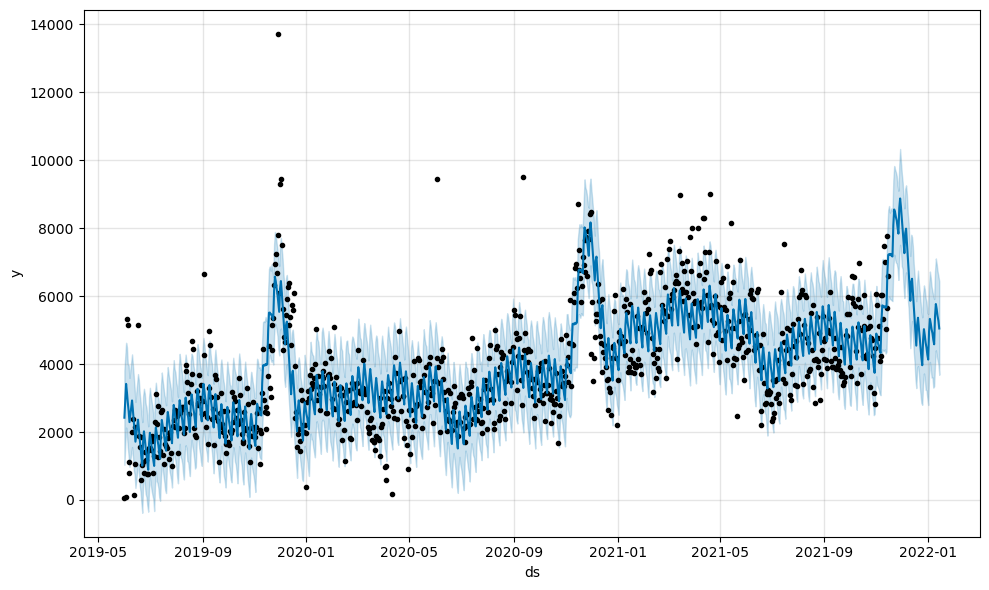

In [384]:
#Graph of historical and forecasted net sales values in Germany
fig61 = m_de.plot(forecast_de)

##### *Metrics Calculation*

In [385]:
r2_score = metrics.r2_score(list(df_de_model_test['y']), list(forecast_de.loc[N_train:,'yhat']))    
print (r2_score)

mae = metrics.mean_absolute_error(list(df_de_model_test['y']), list(forecast_de.loc[N_train:,'yhat']))    
print (mae)

0.41050849074056817
1387.0241660911345


##### *Plot predicted Vs true values*

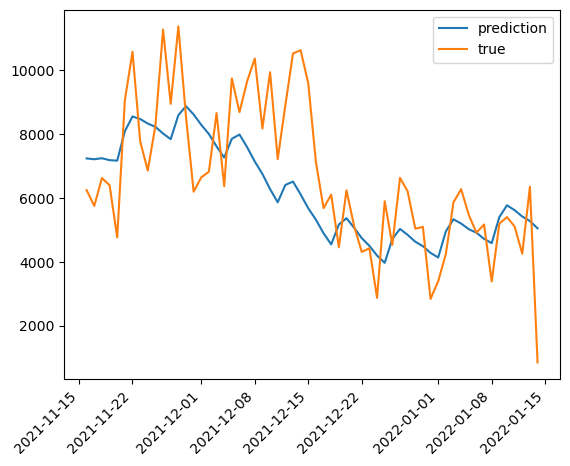

In [386]:
plt.plot(forecast_de.loc[N_train_de:,'ds'],forecast_de.loc[N_train_de:,'yhat'], label = 'prediction')
plt.plot( pd.to_datetime(df_de_model_test['ds']),df_de_model_test['y'], label = 'true')
plt.xticks(rotation=45, ha='right')
plt.legend()

In [387]:
df_de_model_test.describe()

y
count     60.000000
mean    6646.905667
std     2327.498811
min      843.660000
25%     5099.200000
50%     6256.780000
75%     8568.380000
max    11367.750000

##### *Hyperparameter tunning*

In [388]:
# Create the grid
changepoint_prior_scale = [0.01, 0.03, 0.05, 0.07] # default 0.05
seasonality_prior_scale = [1, 5, 10, 15] # default 10
seasonality_mode = ['additive', 'multiplicative']
changepoint_range = [0.6, 0.7, 0.8, 0.9] # default 0.8

# Compute the total number of iterations
total_iter = len(changepoint_prior_scale)*len(seasonality_prior_scale)*len(seasonality_mode)*len(changepoint_range)
print(f'Number of iterations : {total_iter}')

# Loop over the parameters, build and assess the models
grid_search_results = []
iteration = 1
for cps in changepoint_prior_scale:
    for sps in seasonality_prior_scale:
        for sm in seasonality_mode:
            for cr in changepoint_range:
                m_de = Prophet(changepoint_prior_scale = cps, 
                                seasonality_prior_scale = sps, 
                                seasonality_mode = sm, 
                                changepoint_range = cr)
                model_de = m_de.fit(df_de_model_train)
                future_de = model_de.make_future_dataframe(periods=60, freq='D')
                forecast_de = model_de.predict(future_de) 

                r2_score = metrics.r2_score(list(df_de_model_test['y']), list(forecast_de.loc[N_train_de:,'yhat']))   
                mae = metrics.mean_absolute_error(list(df_de_model_test['y']), list(forecast_de.loc[N_train_de:,'yhat']))
                mse = metrics.mean_squared_error(list(df_de_model_test['y']), list(forecast_de.loc[N_train_de:,'yhat']))
                
                print(f'iteration : {iteration} / {total_iter} ')
                print(f'r2_score : {r2_score}')
                print(f'mae : {mae}')
                print(f'mse : {mse}')
                
                grid_search_results.append([iteration, cps, sps, sm, cr, r2_score, mae, mse])
                iteration += 1

# Store the results in a dataframe
grid_search_df_de = pd.DataFrame(grid_search_results, columns = ['iteration', 'cps', 'sps', 'sm', 'cr', 'r2_score', 'mae', 'mse'])


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Number of iterations : 128


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 1 / 128 
r2_score : 0.4346754644594464
mae : 1402.384297452427
mse : 3011462.9990663487


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 2 / 128 
r2_score : 0.43656117952439255
mae : 1399.496559340608
mse : 3001417.864302407


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 3 / 128 
r2_score : 0.43624812648776534
mae : 1399.9817872435613
mse : 3003085.486309379


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 4 / 128 
r2_score : 0.43492095981308765
mae : 1402.0423196894699
mse : 3010155.254350782


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 5 / 128 
r2_score : 0.25180024323191297
mae : 1563.0414829656606
mse : 3985632.5734440093


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 6 / 128 
r2_score : 0.27208646634140066
mae : 1548.8714853918977
mse : 3877568.6093943813


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 7 / 128 
r2_score : 0.25665651168574233
mae : 1559.9211956288063
mse : 3959763.410082372


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 8 / 128 
r2_score : 0.24617202000908955
mae : 1574.5561335848267
mse : 4015613.9114551255


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 9 / 128 
r2_score : 0.4354234529902995
mae : 1401.2991034231668
mse : 3007478.4916855814


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 10 / 128 
r2_score : 0.4356195444109575
mae : 1400.9510714978949
mse : 3006433.919903143


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 11 / 128 
r2_score : 0.4359553312501355
mae : 1400.4756185455963
mse : 3004645.1957664997


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 12 / 128 
r2_score : 0.43641651510078283
mae : 1399.7206757250487
mse : 3002188.486363885


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 13 / 128 
r2_score : 0.253206119514769
mae : 1562.0354176464127
mse : 3978143.5222160495


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 14 / 128 
r2_score : 0.2591955203557983
mae : 1557.3655825146936
mse : 3946238.2043226906


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 15 / 128 
r2_score : 0.2511610256422111
mae : 1564.5299685706589
mse : 3989037.662023614


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 16 / 128 
r2_score : 0.2561523304596791
mae : 1563.5980932104549
mse : 3962449.1649216902


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 17 / 128 
r2_score : 0.43509560755199084
mae : 1401.7922111746839
mse : 3009224.9122720067


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 18 / 128 
r2_score : 0.43673950565318675
mae : 1399.2230878140012
mse : 3000467.9275760334


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 19 / 128 
r2_score : 0.4360464095411769
mae : 1400.28531108642
mse : 3004160.0250614514


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 20 / 128 
r2_score : 0.4370822724726987
mae : 1398.688530055191
mse : 2998642.021340987


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 21 / 128 
r2_score : 0.25683675936978745
mae : 1560.2540116974562
mse : 3958803.237301882


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 22 / 128 
r2_score : 0.25264429715705916
mae : 1563.7643387758262
mse : 3981136.329242678


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 23 / 128 
r2_score : 0.25904465596670145
mae : 1557.7107097072662
mse : 3947041.8533721836


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 24 / 128 
r2_score : 0.2568833790169154
mae : 1562.4991091976406
mse : 3958554.896157054


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 25 / 128 
r2_score : 0.43529606748971217
mae : 1401.4908777773392
mse : 3008157.069559916


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 26 / 128 
r2_score : 0.4359340365461024
mae : 1400.4699646443541
mse : 3004758.631871321


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 27 / 128 
r2_score : 0.43646492568938244
mae : 1399.6500151701334
mse : 3001930.604939737


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 28 / 128 
r2_score : 0.43753029225274787
mae : 1397.959679218445
mse : 2996255.436458062


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 29 / 128 
r2_score : 0.25602848307977366
mae : 1560.7354442483613
mse : 3963108.8953573415


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 30 / 128 
r2_score : 0.2533539993260959
mae : 1562.482975015778
mse : 3977355.7719025165


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 31 / 128 
r2_score : 0.25451179547536407
mae : 1561.3588342141568
mse : 3971188.234417789


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 32 / 128 
r2_score : 0.25913378167218637
mae : 1559.9963032785624
mse : 3946567.0840185466


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 33 / 128 
r2_score : 0.4347965034494231
mae : 1402.6597857326676
mse : 3010818.2288205097


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 34 / 128 
r2_score : 0.44295366242756407
mae : 1370.9687590585247
mse : 2967365.343095879


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 35 / 128 
r2_score : 0.4327094834815757
mae : 1376.7583517779126
mse : 3021935.7073949636


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 36 / 128 
r2_score : 0.42684459967877775
mae : 1378.9480823760366
mse : 3053177.727607409


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 37 / 128 
r2_score : 0.08863808480729785
mae : 1758.8318475471353
mse : 4854791.387635053


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 38 / 128 
r2_score : 0.22145388671481336
mae : 1601.8521399855208
mse : 4147286.497981954


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 39 / 128 
r2_score : 0.3001658352281241
mae : 1522.8505275596892
mse : 3727990.8445470664


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 40 / 128 
r2_score : 0.28377616894199287
mae : 1538.246066317335
mse : 3815297.993776907


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 41 / 128 
r2_score : 0.4324425519874726
mae : 1406.214289160542
mse : 3023357.6416420033


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 42 / 128 
r2_score : 0.44486396029801056
mae : 1369.2536991003064
mse : 2957189.2566315904


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 43 / 128 
r2_score : 0.43452402792800005
mae : 1376.1866033720041
mse : 3012269.6958970847


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 44 / 128 
r2_score : 0.43018922863595976
mae : 1377.7294760907525
mse : 3035361.012221921


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 45 / 128 
r2_score : 0.0875110623857398
mae : 1760.0942151638424
mse : 4860794.994604623


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 46 / 128 
r2_score : 0.2091655993131446
mae : 1611.2134799792439
mse : 4212745.752809156


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 47 / 128 
r2_score : 0.29987974653328475
mae : 1521.9135257699693
mse : 3729514.8284975174


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 48 / 128 
r2_score : 0.3084002306489526
mae : 1514.8013058087288
mse : 3684126.5231342423


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 49 / 128 
r2_score : 0.43458494373494205
mae : 1402.9069924578612
mse : 3011945.1996349706


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 50 / 128 
r2_score : 0.4464121944611631
mae : 1367.6478342543876
mse : 2948941.8702135105


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 51 / 128 
r2_score : 0.43756730857891557
mae : 1374.4525459863937
mse : 2996058.2518506246


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 52 / 128 
r2_score : 0.42893432436417467
mae : 1378.316194329451
mse : 3042045.8411020925


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 53 / 128 
r2_score : 0.08435019494029894
mae : 1763.8184739982037
mse : 4877632.81917878


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 54 / 128 
r2_score : 0.21761394942484646
mae : 1605.4071872889558
mse : 4167741.7026307555


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 55 / 128 
r2_score : 0.30593555308176945
mae : 1515.3043076161619
mse : 3697255.7698440175


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 56 / 128 
r2_score : 0.30105207801842515
mae : 1522.286367049275
mse : 3723269.8618134423


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 57 / 128 
r2_score : 0.4350712964934572
mae : 1402.2102500449794
mse : 3009354.416386262


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 58 / 128 
r2_score : 0.44403746368530683
mae : 1370.0158875817647
mse : 2961591.9736755816


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 59 / 128 
r2_score : 0.434572657834415
mae : 1375.9675042089996
mse : 3012010.6461750045


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 60 / 128 
r2_score : 0.4272402837385092
mae : 1378.7973748892136
mse : 3051069.933180864


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 61 / 128 
r2_score : 0.08442832062979189
mae : 1762.881743208925
mse : 4877216.646505575


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 62 / 128 
r2_score : 0.24320605010299867
mae : 1576.2086638194162
mse : 4031413.524008641


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 63 / 128 
r2_score : 0.3027596600624397
mae : 1520.5591133677008
mse : 3714173.6350973975


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 64 / 128 
r2_score : 0.2867673982230786
mae : 1535.9316126063545
mse : 3799363.825462241


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 65 / 128 
r2_score : 0.4384593962447003
mae : 1395.182849871322
mse : 2991306.1336803674


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 66 / 128 
r2_score : 0.4384367276930662
mae : 1373.8651484960242
mse : 2991426.8882208075


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 67 / 128 
r2_score : 0.4136112712070046
mae : 1384.9680417369395
mse : 3123671.181441198


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 68 / 128 
r2_score : 0.41058489403027254
mae : 1386.9475017857512
mse : 3139792.581302665


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 69 / 128 
r2_score : 0.2060304505993007
mae : 1627.2293972553098
mse : 4229446.574646446


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 70 / 128 
r2_score : 0.367438010994254
mae : 1454.6277478777097
mse : 3369634.4395969836


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 71 / 128 
r2_score : 0.3837176314049817
mae : 1434.2465641651836
mse : 3282913.500696155


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 72 / 128 
r2_score : 0.3695532764218852
mae : 1450.0500361230706
mse : 3358366.4984975858


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 73 / 128 
r2_score : 0.4388114871107588
mae : 1394.2914560913882
mse : 2989430.558592457


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 74 / 128 
r2_score : 0.4354672319201217
mae : 1375.3814117834775
mse : 3007245.282937314


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 75 / 128 
r2_score : 0.4071018062900844
mae : 1389.8590406335684
mse : 3158346.8615304795


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 76 / 128 
r2_score : 0.41259528674068613
mae : 1385.6382226760222
mse : 3129083.2933089747


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 77 / 128 
r2_score : 0.2236546859027566
mae : 1607.236313315147
mse : 4135562.9216886857


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 78 / 128 
r2_score : 0.35818335217974484
mae : 1464.786128050456
mse : 3418933.666566195


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 79 / 128 
r2_score : 0.3761476478984064
mae : 1442.0478311576126
mse : 3323238.5242895433


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 80 / 128 
r2_score : 0.3711331486067191
mae : 1447.592980756342
mse : 3349950.5775021664


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 81 / 128 
r2_score : 0.4388108730500443
mae : 1394.5340465319437
mse : 2989433.829671288


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 82 / 128 
r2_score : 0.4352491390434846
mae : 1375.4847421795298
mse : 3008407.055666185


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 83 / 128 
r2_score : 0.41050849074056817
mae : 1387.0241660911345
mse : 3140199.5788155748


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 84 / 128 
r2_score : 0.40546085317832825
mae : 1391.180136836625
mse : 3167088.158376071


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 85 / 128 
r2_score : 0.23327324449566622
mae : 1595.6811523523036
mse : 4084325.2139900406


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 86 / 128 
r2_score : 0.3412870558081066
mae : 1482.0296104814265
mse : 3508939.615619502


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 87 / 128 
r2_score : 0.38082405605389136
mae : 1436.8517445435964
mse : 3298327.4701190228


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 88 / 128 
r2_score : 0.3768992284191549
mae : 1441.2711280158483
mse : 3319234.882510775


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 89 / 128 
r2_score : 0.43882276650595653
mae : 1394.258296155655
mse : 2989370.473669277


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 90 / 128 
r2_score : 0.4349684831126185
mae : 1375.6310149529884
mse : 3009902.0994828553


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 91 / 128 
r2_score : 0.4123220402069149
mae : 1385.8176918375696
mse : 3130538.8675399576


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 92 / 128 
r2_score : 0.41121102278227684
mae : 1386.5226585107116
mse : 3136457.216479857


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 93 / 128 
r2_score : 0.2309696523151883
mae : 1598.2179989993726
mse : 4096596.364772157


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 94 / 128 
r2_score : 0.3383092206243
mae : 1484.9073897938763
mse : 3524802.4340708125


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 95 / 128 
r2_score : 0.38179884194601277
mae : 1435.8794746371188
mse : 3293134.8215400456


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 96 / 128 
r2_score : 0.371518822201263
mae : 1447.2930168033606
mse : 3347896.1084553287


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 97 / 128 
r2_score : 0.43881137677567206
mae : 1390.9315489889398
mse : 2989431.1463434044


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 98 / 128 
r2_score : 0.4264177670211474
mae : 1379.0768742931098
mse : 3055451.449468814


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 99 / 128 
r2_score : 0.3945773369545498
mae : 1399.9757405545772
mse : 3225064.248828802


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 100 / 128 
r2_score : 0.3970474748757373
mae : 1397.5944474169612
mse : 3211905.9150141655


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 101 / 128 
r2_score : 0.32984540787797956
mae : 1500.9568636708136
mse : 3569888.8531348617


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 102 / 128 
r2_score : 0.39334743757160606
mae : 1424.1742701299606
mse : 3231615.8775861994


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 103 / 128 
r2_score : 0.39568616477179197
mae : 1422.296375607603
mse : 3219157.5638469313


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 104 / 128 
r2_score : 0.39210356883151487
mae : 1427.859324146635
mse : 3238241.920595102


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 105 / 128 
r2_score : 0.43889046215251415
mae : 1392.151290848019
mse : 2989009.861451003


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 106 / 128 
r2_score : 0.42442513374666224
mae : 1379.886560696916
mse : 3066066.133600793


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 107 / 128 
r2_score : 0.3953552098128035
mae : 1399.2454484611224
mse : 3220920.5487355995


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 108 / 128 
r2_score : 0.39887915284206654
mae : 1396.2311259651062
mse : 3202148.633886201


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 109 / 128 
r2_score : 0.32933610727924
mae : 1501.1120615610962
mse : 3572601.878684053


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 110 / 128 
r2_score : 0.3932128795657981
mae : 1424.0909485768673
mse : 3232332.6631319234


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 111 / 128 
r2_score : 0.3955176968079652
mae : 1423.0413977288058
mse : 3220054.986491267


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 112 / 128 
r2_score : 0.3924272443722342
mae : 1427.1226054069796
mse : 3236517.7128996993


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 113 / 128 
r2_score : 0.4374948755937138
mae : 1396.022055543394
mse : 2996444.09969754


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 114 / 128 
r2_score : 0.42799531001515
mae : 1378.4472045584034
mse : 3047047.935987248


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 115 / 128 
r2_score : 0.39709524397445306
mae : 1397.6164736114301
mse : 3211651.450783025


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 116 / 128 
r2_score : 0.39098652734540673
mae : 1403.1860396987906
mse : 3244192.3594887904


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 117 / 128 
r2_score : 0.32782416059972885
mae : 1502.9659338356416
mse : 3580655.963012015


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 118 / 128 
r2_score : 0.3922030926296757
mae : 1424.9316524331173
mse : 3237711.760984391


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 119 / 128 
r2_score : 0.3958734955578871
mae : 1422.3243417114566
mse : 3218159.659642452


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 120 / 128 
r2_score : 0.3925123344865522
mae : 1427.2147027589854
mse : 3236064.4409917146


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 121 / 128 
r2_score : 0.43787347996032266
mae : 1394.83806580734
mse : 2994427.2881677924


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 122 / 128 
r2_score : 0.4288375611891905
mae : 1378.1177124383569
mse : 3042561.2949747224


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 123 / 128 
r2_score : 0.39951723825001706
mae : 1395.8313660601546
mse : 3198749.576397125


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 124 / 128 
r2_score : 0.3988229370725387
mae : 1396.2473593434386
mse : 3202448.093221952


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 125 / 128 
r2_score : 0.33296014737945745
mae : 1497.8393691512326
mse : 3553296.7504208656


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 126 / 128 
r2_score : 0.3928175651119039
mae : 1424.3123473133496
mse : 3234438.488681773


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration : 127 / 128 
r2_score : 0.39577072237487787
mae : 1421.9795613717608
mse : 3218707.128606686
iteration : 128 / 128 
r2_score : 0.3926912232048727
mae : 1425.3639709505312
mse : 3235111.5073716347


In [389]:
grid_search_df_de

iteration   cps  sps              sm   cr  r2_score          mae  \
0            1  0.01    1        additive  0.6  0.434675  1402.384297   
1            2  0.01    1        additive  0.7  0.436561  1399.496559   
2            3  0.01    1        additive  0.8  0.436248  1399.981787   
3            4  0.01    1        additive  0.9  0.434921  1402.042320   
4            5  0.01    1  multiplicative  0.6  0.251800  1563.041483   
..         ...   ...  ...             ...  ...       ...          ...   
123        124  0.07   15        additive  0.9  0.398823  1396.247359   
124        125  0.07   15  multiplicative  0.6  0.332960  1497.839369   
125        126  0.07   15  multiplicative  0.7  0.392818  1424.312347   
126        127  0.07   15  multiplicative  0.8  0.395771  1421.979561   
127        128  0.07   15  multiplicative  0.9  0.392691  1425.363971   

              mse  
0    3.011463e+06  
1    3.001418e+06  
2    3.003085e+06  
3    3.010155e+06  
4    3.985633e+06  
..            ...  
123  3.202448e+06  
124  3.553297e+06  
125  3.234438e+06  
126  3.218707e+06  
127  3.235112e+06  

[128 rows x 8 columns]